# How can frog grow its tail back?

## Overview
This notebook provides an end-to-end workflow for processing single-cell RNA-seq data, reproducing key aspects of the analysis described in [Xu et al., Science (2020)](https://www.science.org/doi/10.1126/science.aav9996).


## Section 1: Data Import, Preprocessing, and Target Gene Definition

### Import required Python packages.

In [ ]:
# !pip install anndata
# !pip install scanpy
# !pip install python-louvain

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 189.0/189.0 kB 1.1 MB/s eta 0:00:00ta 0:00:01


In [ ]:
# ------------------------------
# RUN below if you do not have 'cleaned_processed_frogtail.h5ad'
# ------------------------------

# import zipfile
# import os
# import scanpy as sc
# import anndata as ad
# import numpy as np
# import pandas as pd
# from scipy.io import mmread

# !wget https://ftp.ebi.ac.uk/biostudies/fire/E-MTAB-/716/E-MTAB-7716/Files/arrayExpressUpload.zip -O /content/frogtail.zip
# zip_file = "/content/frogtail.zip" # replace path to your zip file's path
# extract_dir = "/content/drive/MyDrive/TA/Frogtail_files/" # where zip file is going to be extracted to

# os.makedirs(extract_dir, exist_ok=True) # create the extraction directory if it doesn't exist

# with zipfile.ZipFile(zip_file, 'r') as zip_ref: # unzip
#     zip_ref.extractall(extract_dir)

# print(f"Files extracted to {extract_dir}")
# zip_file = extract_dir+"ArrayExpressV2.zip" # file is a nested zip, dezip again

# with zipfile.ZipFile(zip_file, 'r') as zip_ref: # unzip
#     zip_ref.extractall(extract_dir)

# print(f"Files extracted to {extract_dir}")

# X = mmread(extract_dir+'ArrayExpress/countsMatrix.mtx') # compressed sparse matrix of gene expression
# genes = pd.read_csv(extract_dir+'ArrayExpress/genes.csv', sep=' ', header=None) # col names of genes
# cells = pd.read_csv(extract_dir+'ArrayExpress/cells.csv', sep=' ', header=None) # row names of cells
# labels = pd.read_csv(extract_dir+'ArrayExpress/labels.csv')
# meta = pd.read_csv(extract_dir+'ArrayExpress/meta.csv')

# adata = ad.AnnData(X.T)
# cells.columns = ['barcode_cells']
# meta_aug = pd.merge(meta, labels, left_on='sample', right_on='Sample', how='left')
# adata.var_names = genes[0]
# adata.obs = pd.merge(cells, meta_aug, left_on='barcode_cells', right_on='cell')
# adata.X = adata.X.tocsr()
# adata.write_h5ad(extract_dir+'cleaned_processed_frogtail.h5ad')


### Load your AnnData object (`adata`) that contains your single-cell data.



In [ ]:
import anndata as ad
# extract_dir = "/Datasets/"
adata = ad.read_h5ad('Frogtail_files/cleaned_processed_frogtail.h5ad') # ad.read_h5ad()
adata.X.todense()

/home/fangxy/anaconda3/lib/python3.11/site-packages/anndata/_core/aligned_df.py:68: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


matrix([[0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        ...,
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0],
        [0, 0, 0, ..., 0, 0, 0]])

### get the true label cell type annotations according to the given cluster names

In [ ]:
list(adata.obs['cluster'].unique())

['Erythrocyte 4',
 'Myeloid 1',
 'Beta ionocyte',
 'Goblet cell',
 'Erythrocyte 1',
 'Epidermis',
 'Sclerotome',
 'Myotome',
 'Spinal cord progenitor',
 'Myeloid 2',
 'Mesenchyme',
 'ROCs',
 'Melanocyte',
 'Erythrocyte 3',
 'Differentiating neuron',
 'Satellite cell',
 'Vascular endothelial cell',
 'Vulnerable Motor Neuron',
 'Alpha ionocyte',
 'Lymphoid 1 (Gata2-, Gata3+)',
 'Lymphoid 2 (Cxcr6+)',
 'Erythrocyte 2',
 'Interneuron 1',
 'Skeletal muscle',
 'Lymphoid 4 (Gata2+, Gata3-)',
 'Small secretory cell',
 'Floor plate',
 'Dermomyotome',
 'Interneuron 2',
 'Dopaminergic neurons',
 'Lymphoid 5 (CD19+)',
 'Interneuron 4',
 'Melanocyte stem cell',
 'laminin-rich epidermis',
 'Motor neuron (leptin+)',
 'Motor neuron',
 'Lymphoid 3',
 'Posterior notochord',
 'Melanocyte precursor',
 'Anterior notochord',
 'Interneuron 3',
 'Smooth muscle',
 'Syndetome',
 'Differentiating myocyte',
 'Oligodendrocyte',
 'Lymphoid endothelial cells']

In [ ]:
mapping_dict = {
    # Somite and others
    'Skeletal muscle': 'Somite and others',
    'Differentiating myocyte': 'Somite and others',
    'Mesenchyme': 'Somite and others',
    'Myotome': 'Somite and others',
    'Sclerotome': 'Somite and others',
    'Satellite cell': 'Somite and others',
    'Syndetome': 'Somite and others',
    'Smooth muscle': 'Somite and others',
    'Dermomyotome': 'Somite and others',
    'Posterior notochord': 'Somite and others',
    'Anterior notochord': 'Somite and others',


    # Skin
    'Epidermis': 'Skin',
    'laminin-rich epidermis': 'Skin',
    'Goblet cell': 'Skin',
    'Beta ionocyte': 'Skin',
    'Alpha ionocyte': 'Skin',
    'Small secretory cell': 'Skin',
    'Melanocyte': 'Skin',
    'Melanocyte precursor': 'Skin',
    'Melanocyte stem cell': 'Skin',
    'ROCs': 'Skin',

    # Neural
    'Spinal cord progenitor': 'Neural',
    'Differentiating neuron': 'Neural',
    'Interneuron 1': 'Neural',
    'Interneuron 2': 'Neural',
    'Interneuron 3': 'Neural',
    'Interneuron 4': 'Neural',
    'Motor neuron': 'Neural',
    'Motor neuron (leptin+)': 'Neural',
    'Dopaminergic neurons': 'Neural',
    'Oligodendrocyte': 'Neural',
    'Vulnerable Motor Neuron': 'Neural',
    'Floor plate': 'Neural',

    # Immune
    'Myeloid 1': 'Immune',
    'Myeloid 2': 'Immune',
    'Lymphoid 1 (Gata2-, Gata3+)': 'Immune',
    'Lymphoid 2 (Cxcr6+)': 'Immune',
    'Lymphoid 3': 'Immune',
    'Lymphoid 4 (Gata2+, Gata3-)': 'Immune',
    'Lymphoid 5 (CD19+)': 'Immune',
    'Lymphoid endothelial cells': 'Immune',

    # Red blood cells
    'Erythrocyte 1': 'Red blood cells',
    'Erythrocyte 2': 'Red blood cells',
    'Erythrocyte 3': 'Red blood cells',
    'Erythrocyte 4': 'Red blood cells',

}

adata.obs['broad_cell_type'] = adata.obs['cluster'].map(mapping_dict)

### Preprocess data: Normalization, log1p transformation, cell/gene filtering, HVG selection.

Note that after choosing the top 2300 highly variable genes, some marker genes for ROCs like "wnt5a" are gone. So we choose to select HVGs by the author's method:

*Highly variable genes (Fano factor > 65th percentile, HVGs) were selected for clustering and visualization, with both lowly (mean expression < 5th percentile) and highly expressed (mean expression > 80th percentile) genes removed to minimize batch effects.*


In [ ]:
import scanpy as sc
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import umap
import igraph as ig
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, adjusted_rand_score

adata.layers["counts"] = adata.X.copy()

In [ ]:
# --- Step 1: Data Preprocessing ---
# (Optional: Subset data if needed, e.g. by DaysPostAmputation)
# adata = adata_original[adata_original.obs['DaysPostAmputation'] == 0].copy()

# Normalize total counts per cell to 1e4 and log-transform the data
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

# Filter out low-quality cells and lowly expressed genes
# sc.pp.filter_genes(adata, min_cells=3)
# sc.pp.filter_cells(adata, min_genes=200)

# --- Step 2: Compute HVG Statistics ---
# Convert adata.X to a dense array if it is sparse.
if hasattr(adata.X, "A"):
    X = adata.X.A
else:
    X = adata.X

# Compute the mean expression per gene (across cells)
gene_means = np.mean(X, axis=0)

# Compute the variance per gene
gene_vars = np.var(X, axis=0)

# Compute the Fano factor for each gene: variance / mean
eps = 1e-10  # Small constant to avoid division by zero
fano_factor = gene_vars / (gene_means + eps)

# --- Step 3: Determine Thresholds for HVG Selection ---
# Remove genes with mean expression below the 5th percentile or above the 80th percentile.
low_mean_threshold  = np.quantile(gene_means, 0.05)
high_mean_threshold = np.quantile(gene_means, 0.8)
# Only select genes with a Fano factor above the 65th percentile.
fano_threshold      = np.nanquantile(fano_factor, 0.65)

print("Low mean threshold (5th percentile):", low_mean_threshold)
print("High mean threshold (80th percentile):", high_mean_threshold)
print("Fano factor threshold (65th percentile):", fano_threshold)

# --- Step 4: Filter Out Genes with Non-Finite Means ---
finite_idx = np.isfinite(gene_means)
adata = adata[:, finite_idx]

# --- Step 5: Identify Genes that Meet the HVG Criteria ---
# Create a boolean array for all genes indicating if they pass the thresholds.
# Note: gene_means and fano_factor are computed on the original full gene set.
selected = (gene_means >= low_mean_threshold) & (gene_means <= high_mean_threshold) & (fano_factor >= fano_threshold)

# Ensure that 'selected' only refers to the genes that are still in adata.var.
# Because we filtered adata with finite_idx, we must also subset our boolean array:
selected = selected[finite_idx]

# Add the boolean array as a new column 'highly_variable' to adata.var.
adata.var['highly_variable'] = selected
print("Number of selected HVGs:", np.sum(adata.var['highly_variable']))

# Subset the AnnData object to include only highly variable genes.
adata = adata[:, adata.var['highly_variable']]

# --- Step 6: Remove Cells with Zero Expression Across All HVGs ---
cell_expr_sum = np.sum(adata.X, axis=1)
cells_to_keep = np.where(cell_expr_sum > 0)[0]
adata = adata[cells_to_keep, :]

Low mean threshold (5th percentile): 0.0
High mean threshold (80th percentile): 0.07334184608862848
Fano factor threshold (65th percentile): 0.8723219918983433


/tmp/ipykernel_655607/2678016039.py:55: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['highly_variable'] = selected


Number of selected HVGs: 9154


## Section 2: Dimensionality Reduction and Clustering

### UMAP
We adopt UMAP parameters that are consistent with the article:

*To perform clustering, we first constructed a graph to represent the similarity structure of the data. Instead of using a standard k-nearest-neighbor graph, we constructed the graph in the same manner as UMAP does for high-dimensional data visualization. Specifically, we built a fuzzy topological representation of the data as a weighted graph by applying UMAP’s `fuzzy_simplicial_set` function. This was done using log2-transformed highly variable genes (HVGs), with cosine distance as the similarity measure, and using k = 10 nearest neighbors.*

In [ ]:
# create UMAP reducer with parameters according to the article
umap_reducer = umap.UMAP(
    n_neighbors=10,      # Each cell considers 10 nearest neighbors
    min_dist=0.4,        # Controls how close points can get in the embedding
    n_components=2,      # Project data to 2 dimensions for visualization
    metric='cosine',     # Use cosine distance for cell similarities
    random_state=42,     # Set random seed for reproducibility
    set_op_mix_ratio=1.0,# Adjusts construction of the fuzzy simplicial set
    local_connectivity=1 # Minimum connectivity in the local neighborhood
)

# Ensure X_data has the correct shape: (n_obs, n_features)
X_data = adata.X.A if hasattr(adata.X, "A") else adata.X

# Compute UMAP embedding
umap_embedding = umap_reducer.fit_transform(X_data)
adata.obsm['X_umap'] = umap_embedding  # Store UMAP coordinates in AnnData


/home/fangxy/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/tmp/ipykernel_655607/3999281062.py:17: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  adata.obsm['X_umap'] = umap_embedding  # Store UMAP coordinates in AnnData


### Comparing methods and parameters

---



#### Dimensionality Reduction with PCA
- Reduce the dimensionality of the data using PCA.
- Determine the optimal number of components (n_comp) by plotting the cumulative explained variance and identifying the "elbow" in the curve.

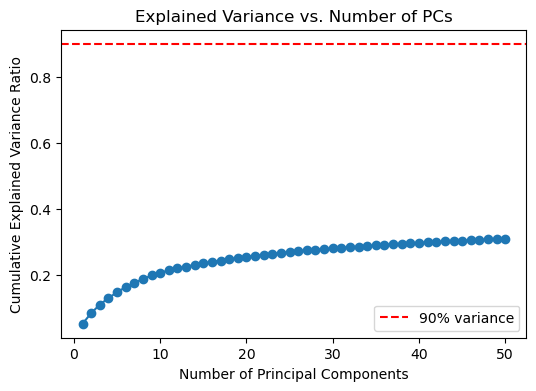

In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

# Run PCA on adata using a high number of components (e.g., 50) to capture the explained variance.
sc.pp.pca(adata, n_comps=50, random_state=42)

# Retrieve the explained variance ratio from the PCA results.
explained_var = adata.uns['pca']['variance_ratio']

# Compute cumulative explained variance.
cumulative_explained = np.cumsum(explained_var)

# Plot cumulative explained variance to visualize the elbow.
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(cumulative_explained) + 1), cumulative_explained, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance vs. Number of PCs')
# Optional: Add a horizontal line at 0.90 (90%) to guide the eye.
plt.axhline(y=0.90, color='r', linestyle='--', label='90% variance')
plt.legend()
plt.show()


When looking at a plot of cumulative explained variance versus the number of principal components (PCs), we're trying to see how much of the total variance in our dataset is captured as we add more components.

- In this figure, we can see that the slope decreases steadily, and there isn't a strong, classic elbow. The variance explained continues to rise but at a diminishing rate.

- Even with 50 PCs, we don't reach 90% variance explained. This is not unusual in high-dimensional, noisy single-cell data.

- In single-cell analysis, it's common to use 20-50 PCs.

- Ultimately, we can choose a few candidate PC counts (e.g., 10, 20, 30, 50) and test downstream results—such as clustering metrics (ARI, Silhouette) or biological interpretability—to see which performs best.  

**Summary:**  
Because the curve doesn’t show a clear elbow and remains well below 90% even at 50 PCs, we pick a few candidate PC counts (e.g., 10, 20, 30, 50) then validate via downstream analyses (e.g., clustering scores, cell-type markers) to deicide the parameter.





---


#### Evaluating Clustering Quality Across PCA and Leiden Resolution Parameters

In this section, we explore how the clustering quality changes when varying two key parameters:
- **PCA Components**: The number of principal components used for building the neighbors graph.
- **Leiden Resolution**: The resolution parameter controlling the granularity of the Leiden clustering.

We define a range of values for each parameter:
- **PCA Components**: [5, 10, 20, 50]
- **Leiden Resolution**: [0.1, 0.5, 1.0]

For each combination of these parameters, we:
1. Run PCA on the data using the specified number of components.
2. Construct a neighbors graph based on the PCA embedding.
3. Perform Leiden clustering at the specified resolution.
4. Calculate the Adjusted Rand Index (ARI) by comparing the obtained clustering labels with the ground truth labels stored in `adata.obs['cluster']`.

Finally, we store the ARI scores in a matrix and visualize the results as a heatmap.



Running PCA with n_comps = 5


/tmp/ipykernel_655607/3508880138.py:24: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, resolution=res, key_added=key)


PCA n_comps = 5, resolution = 0.1, ARI Score = 0.562
PCA n_comps = 5, resolution = 0.5, ARI Score = 0.443
PCA n_comps = 5, resolution = 1.0, ARI Score = 0.310

Running PCA with n_comps = 10
PCA n_comps = 10, resolution = 0.1, ARI Score = 0.590
PCA n_comps = 10, resolution = 0.5, ARI Score = 0.535
PCA n_comps = 10, resolution = 1.0, ARI Score = 0.432

Running PCA with n_comps = 20
PCA n_comps = 20, resolution = 0.1, ARI Score = 0.593
PCA n_comps = 20, resolution = 0.5, ARI Score = 0.573
PCA n_comps = 20, resolution = 1.0, ARI Score = 0.477

Running PCA with n_comps = 50


PCA n_comps = 50, resolution = 0.1, ARI Score = 0.594
PCA n_comps = 50, resolution = 0.5, ARI Score = 0.661
PCA n_comps = 50, resolution = 1.0, ARI Score = 0.522


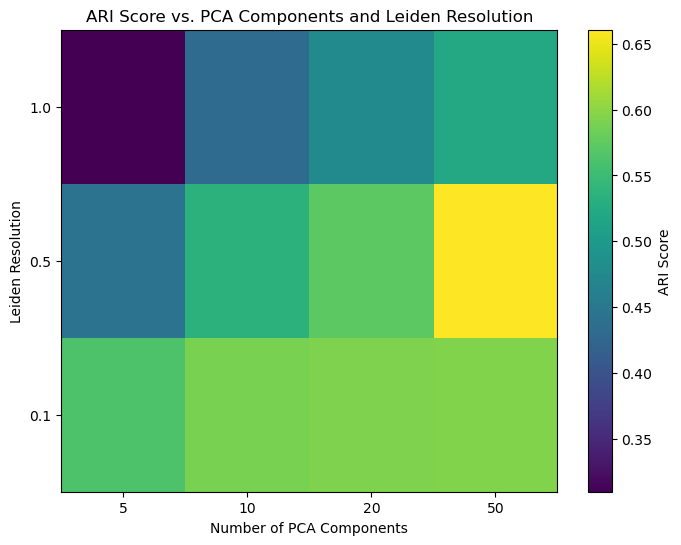

In [ ]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
from sklearn.metrics import adjusted_rand_score

# Define the parameter ranges
pca_components_list = [5, 10, 20, 50]  # different numbers of PCA components
resolutions = [0.1, 0.5, 1.0]          # different Leiden resolution values

# Prepare an array to store ARI scores.
ari_matrix = np.zeros((len(resolutions), len(pca_components_list)))

# Loop over each combination of PCA components and Leiden resolution.
for i, n_comps in enumerate(pca_components_list):
    print(f"\nRunning PCA with n_comps = {n_comps}")
    # Run PCA using the specified number of components.
    sc.pp.pca(adata, n_comps=n_comps, random_state=42)

    # Compute the neighbors graph using the PCA results.
    sc.pp.neighbors(adata, n_neighbors=20, n_pcs=n_comps)

    for j, res in enumerate(resolutions):
        key = f'leiden_{n_comps}_{res}'
        sc.tl.leiden(adata, resolution=res, key_added=key)
        labels = adata.obs[key].astype(str)
        # Compute the ARI score using the ground truth labels in adata.obs['cluster']
        ari = adjusted_rand_score(adata.obs['cluster'], labels)
        ari_matrix[j, i] = ari
        print(f"PCA n_comps = {n_comps}, resolution = {res}, ARI Score = {ari:.3f}")

# Plot the heatmap of ARI scores without using 'extent'.
plt.figure(figsize=(8, 6))
im = plt.imshow(ari_matrix, aspect='auto', origin='lower', cmap='viridis')

# Add a colorbar
plt.colorbar(im, label='ARI Score')

# Set the tick positions and labels manually.
# x-axis should correspond to the PCA components, y-axis to the resolutions.
plt.xticks(np.arange(len(pca_components_list)), pca_components_list)
plt.yticks(np.arange(len(resolutions)), resolutions)

plt.xlabel('Number of PCA Components')
plt.ylabel('Leiden Resolution')
plt.title('ARI Score vs. PCA Components and Leiden Resolution')
plt.show()


To maximize ARI, we look for the combination that yields the highest score (the brightest cell in the heatmap). For instance, at `n_comps=50` and `resolution=0.5`, the ARI is relatively high (yellow region).



---


#### Fixing PCA at 50 and Exploring Leiden Resolutions

So we decided to use **50 principal components**, we proceed with the following steps to help **fine-tune the Leiden resolution**, providing a quantitative basis (Silhouette and Modularity) to guide the optimal choice for downstream analysis.


1. **PCA & Neighbors Graph**  
   - We run PCA with `n_comps=50` on the data and construct a neighbors graph using 20 neighbors. This graph serves as the foundation for clustering and subsequent modularity calculations.

2. **Building an igraph for Modularity**  
   - We retrieve the connectivity matrix (either from `adata.obsp['connectivities']` or `adata.uns['neighbors']['connectivities']`), convert it to a CSR matrix if needed, and binarize it (nonzero entries are treated as edges).
   - We then create an undirected `igraph` object from this adjacency matrix, assigning edge weights based on the connectivity values.

3. **Evaluating Different Leiden Resolutions**  
   - We iterate over a range of resolutions (0.1 to 1.0 in steps of 0.1). For each resolution:
     1. **Leiden Clustering**: Run Leiden with the chosen resolution and store labels in `adata.obs[key]`.
     2. **Silhouette Score**: Use the PCA embedding (50 PCs) to compute how well-separated the clusters are.
     3. **Modularity**: Convert the string labels to integer partitions and compute the modularity score on the igraph graph, indicating how strongly the network is subdivided into these clusters.
   - Both metrics (Silhouette and Modularity) are recorded and printed for each resolution.

4. **Plotting Silhouette and Modularity**  
   - We produce two line plots side by side:
     - **Silhouette Score vs. Resolution**: Illustrates how the cluster cohesion/separation changes as resolution varies.
     - **Modularity vs. Resolution**: Shows how well the network is partitioned into modules (clusters), with higher values indicating stronger community structure.
   - By examining these curves, we can select a resolution that balances both Silhouette (local structure) and Modularity (global community strength).



Resolution 0.1: Silhouette = 0.328, Modularity = 0.781
Resolution 0.2: Silhouette = 0.211, Modularity = 0.812
Resolution 0.3: Silhouette = 0.161, Modularity = 0.840
Resolution 0.4: Silhouette = 0.175, Modularity = 0.841
Resolution 0.5: Silhouette = 0.194, Modularity = 0.844
Resolution 0.6: Silhouette = 0.187, Modularity = 0.853
Resolution 0.7: Silhouette = 0.185, Modularity = 0.853
Resolution 0.8: Silhouette = 0.181, Modularity = 0.853
Resolution 0.9: Silhouette = 0.189, Modularity = 0.852
Resolution 1.0: Silhouette = 0.188, Modularity = 0.848


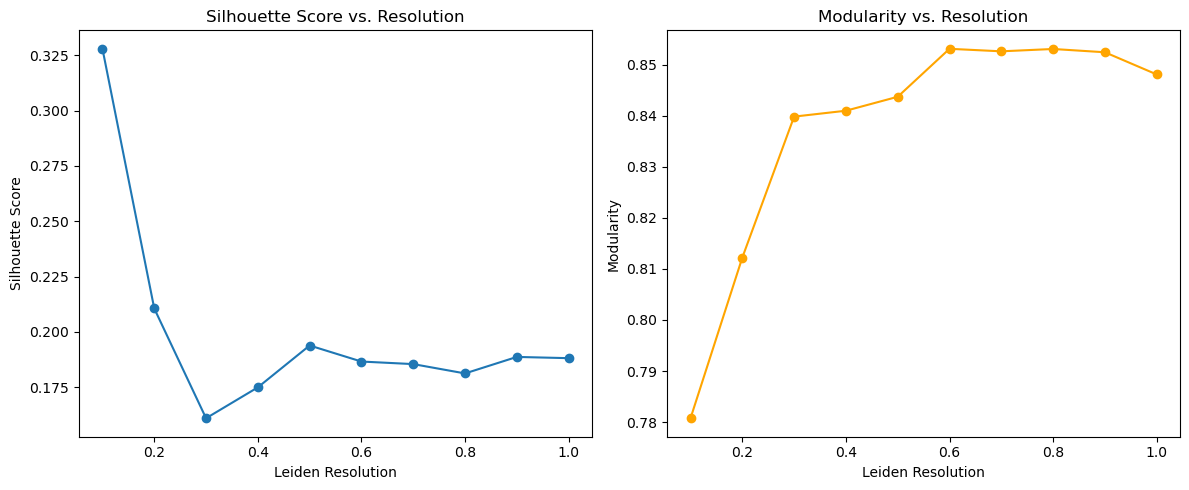

In [ ]:
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score
import igraph as ig
import scipy.sparse as sp

# ------------------------------
# Step 1: Run PCA with n_comps=50 and compute neighbors
# ------------------------------
sc.pp.pca(adata, n_comps=50, random_state=42)
sc.pp.neighbors(adata, n_neighbors=20, n_pcs=50, random_state=42)

# ------------------------------
# Step 2: Convert the neighbors graph to an igraph object for modularity calculation
# ------------------------------
if 'neighbors' in adata.uns and 'connectivities' in adata.uns['neighbors']:
    connectivities = adata.uns['neighbors']['connectivities']
elif 'connectivities' in adata.obsp:
    connectivities = adata.obsp['connectivities']
else:
    raise KeyError("Connectivity matrix not found.")

if not sp.isspmatrix_csr(connectivities):
    connectivities = sp.csr_matrix(connectivities)

# Create a binary adjacency matrix (non-zero entries as edges)
adj_matrix = (connectivities > 0).astype(int)

# Convert to igraph (undirected graph)
g = ig.Graph.Adjacency(adj_matrix.toarray().tolist(), mode=ig.ADJ_UNDIRECTED)
g.es['weight'] = connectivities.data.tolist()

# ------------------------------
# Step 3: Evaluate Leiden clustering with different resolution values
# ------------------------------
resolutions = np.arange(0.1, 1.1, 0.1)  # from 0.1 to 1.0
sil_scores = []
modularity_scores = []

for res in resolutions:
    key = f'leiden_{res:.1f}'
    sc.tl.leiden(adata, resolution=res, key_added=key)
    # Get clustering labels as strings
    labels_str = adata.obs[key].astype(str).tolist()

    # Convert PCA embedding to use for silhouette score (using all 50 PCs)
    sil = silhouette_score(adata.obsm['X_pca'], labels_str)
    sil_scores.append(sil)

    # Convert string labels to integer partition for modularity calculation
    unique_labels = sorted(set(labels_str))
    label_to_int = {label: i for i, label in enumerate(unique_labels)}
    partition = [label_to_int[label] for label in labels_str]
    mod = g.modularity(partition, weights='weight')
    modularity_scores.append(mod)

    print(f"Resolution {res:.1f}: Silhouette = {sil:.3f}, Modularity = {mod:.3f}")

# ------------------------------
# Step 4: Plot the evaluation metrics vs. resolution
# ------------------------------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(resolutions, sil_scores, marker='o')
plt.xlabel('Leiden Resolution')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score vs. Resolution')

plt.subplot(1,2,2)
plt.plot(resolutions, modularity_scores, marker='o', color='orange')
plt.xlabel('Leiden Resolution')
plt.ylabel('Modularity')
plt.title('Modularity vs. Resolution')

plt.tight_layout()
plt.show()


#### Selecting Leiden Resolutions: 0.1 and 0.5

From the plots above, we observe how **Silhouette Score** (left) and **Modularity** (right) change as we vary the Leiden resolution from 0.1 to 1.0. Here, we choose two specific resolutions:

- **Resolution = 0.1**  
  - Produces **fewer clusters**, which aligns with the low-resolution setting used in Figure 1.A of the referenced article. This setting helps replicate a more coarse-grained clustering structure similar to the one shown in that figure.

- **Resolution = 0.5**  
  - Strikes a balance between Silhouette and Modularity, yielding a **moderate number of clusters** that replicates the more detailed clustering in Figure 1.B. This setting captures additional substructure without fragmenting the data into too many small clusters.

By selecting these two resolutions, we aim to **reproduce** the key clustering figures from the article (Fig. 1.A and Fig. 1.B) under the same conditions described in their methods.




---


#### Additional Clustering Methods: Louvain, KMeans, and Walktrap

In addition to Leiden clustering, we compare three other approaches:

- **Louvain**
- **KMeans**  

  Since KMeans is very likely to perform poorly when the desired number of clusters is large, we fix the data to 5 clusters.
  
- **Walktrap**

  Operating on the fuzzy UMAP graph to replicate the paper's approach to graphical clustering.  

  (The same method used by the authors. The random seed given by the author in his R code is 42, so we can't generate exactly the same plot since the seed isn't same in python.)


In [ ]:
import scanpy as sc
import anndata as ad
import numpy as np
import matplotlib.pyplot as plt
import umap
import igraph as ig
from scipy.sparse import csr_matrix
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
import random
# Set seeds for reproducibility
np.random.seed(42)
random.seed(42)

# ------------------------------
# (a) Louvain Clustering
# ------------------------------
# Run Louvain clustering using the 'igraph' flavor.
# This requires the python-louvain package to be installed.
sc.tl.louvain(adata, flavor='igraph', key_added='louvain')

# ------------------------------
# (c) KMeans Clustering
# ------------------------------
# Run KMeans clustering on the PCA results.
# Here, we force the data into 5 clusters.
kmeans = KMeans(n_clusters=5, random_state=42)
adata.obs['kmeans'] = kmeans.fit_predict(adata.obsm['X_pca']).astype(str)

# ------------------------------
# (d) Walktrap Clustering using UMAP Fuzzy Set
# ------------------------------
# It is assumed that 'umap_reducer' is already defined and has been used to compute UMAP.
# Retrieve the fuzzy simplicial set (graph) from UMAP.
fuzzy_graph = umap_reducer.graph_
if not isinstance(fuzzy_graph, csr_matrix):
    fuzzy_graph = csr_matrix(fuzzy_graph)

# Convert the fuzzy graph to COOrdinate format.
coo = fuzzy_graph.tocoo()

# Build an igraph graph from the fuzzy graph.
# Create a graph with one vertex per cell.
g = ig.Graph()
g.add_vertices(fuzzy_graph.shape[0])
# Add edges from the nonzero entries of the fuzzy graph.
edges = list(zip(coo.row, coo.col))
g.add_edges(edges)
# Assign edge weights based on the connectivity values.
g.es['weight'] = coo.data.tolist()

# Perform Walktrap clustering on the graph (using 10 steps).
walktrap_result = g.community_walktrap(weights='weight', steps=10)
clusters = walktrap_result.as_clustering()
# Store the Walktrap clustering results in adata.obs.
adata.obs['walktrap'] = [str(x) for x in clusters.membership]

/home/fangxy/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


#### Evaluating Clustering Performance Across Methods

**Computing Clustering Evaluation Metrics**  
   - We evaluate five clustering methods: Louvain, two Leiden variants (at resolutions 0.1 and 0.5), KMeans (forced to 5 clusters), and Walktrap.  
   - For each method, we calculate several evaluation metrics using the PCA embedding (50 PCs):
     - **Silhouette Score** (higher is better)
     - **Adjusted Rand Index (ARI)** (if true labels are available in `adata.obs['cluster']`; higher is better)
     - **Calinski-Harabasz Score** (higher is better)
     - **Davies-Bouldin Score** (lower is better)
     - **Adjusted Mutual Information (AMI)** (higher is better)
     - **Modularity** (computed on the igraph; higher is better)
   - The scores for each method are stored in a matrix and then converted into a DataFrame for easy comparison.

In [ ]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.metrics import silhouette_score, adjusted_rand_score, calinski_harabasz_score, davies_bouldin_score, adjusted_mutual_info_score
import igraph as ig
import scipy.sparse as sp

methods = ['louvain', 'leiden_0.1', 'leiden_0.5', 'kmeans', 'walktrap']
metrics = ['Silhouette', 'ARI', 'Calinski-Harabasz', 'Davies-Bouldin', 'AMI', 'Modularity']
results_dict = {m: {} for m in methods}

# Use the PCA embedding (all 50 PCs) for metric calculations.
pca_data = adata.obsm['X_pca']

for m in methods:
    # Get the clustering labels as strings.
    labels_str = adata.obs[m].astype(str).tolist()

    # Silhouette Score (higher is better).
    sil = silhouette_score(pca_data, labels_str)
    results_dict[m]['Silhouette'] = sil

    # ARI (if true labels are available in adata.obs['cluster'], otherwise NaN).
    if 'cluster' in adata.obs:
        ari = adjusted_rand_score(adata.obs['cluster'], labels_str)
    else:
        ari = np.nan
    results_dict[m]['ARI'] = ari

    # Calinski-Harabasz Score (higher is better).
    ch = calinski_harabasz_score(pca_data, labels_str)
    results_dict[m]['Calinski-Harabasz'] = ch

    # Davies-Bouldin Score (lower is better).
    db = davies_bouldin_score(pca_data, labels_str)
    results_dict[m]['Davies-Bouldin'] = db

    # AMI (higher is better).
    if 'cluster' in adata.obs:
        ami = adjusted_mutual_info_score(adata.obs['cluster'], labels_str)
    else:
        ami = np.nan
    results_dict[m]['AMI'] = ami

    # Modularity: Convert string labels to integer partition.
    unique_labels = sorted(set(labels_str))
    label_to_int = {label: i for i, label in enumerate(unique_labels)}
    partition = [label_to_int[label] for label in labels_str]
    mod = g.modularity(partition, weights='weight')
    results_dict[m]['Modularity'] = mod

    print(f"Method {m}: Silhouette={sil:.3f}, ARI={ari:.3f}, CH={ch:.3f}, DB={db:.3f}, AMI={ami:.3f}, Modularity={mod:.3f}")

# Convert the results into a DataFrame (rows: methods, columns: metrics).
df_metrics = pd.DataFrame(results_dict).T
print("\nClustering Evaluation Metrics:")
print(df_metrics)


Method louvain: Silhouette=0.150, ARI=0.569, CH=1262.266, DB=1.456, AMI=0.750, Modularity=0.701
Method leiden_0.1: Silhouette=0.328, ARI=0.623, CH=1439.955, DB=1.325, AMI=0.757, Modularity=0.774
Method leiden_0.5: Silhouette=0.194, ARI=0.617, CH=1325.287, DB=1.321, AMI=0.774, Modularity=0.743
Method kmeans: Silhouette=0.347, ARI=0.290, CH=2023.756, DB=1.709, AMI=0.557, Modularity=0.595
Method walktrap: Silhouette=0.106, ARI=0.581, CH=899.470, DB=1.872, AMI=0.791, Modularity=0.847

Clustering Evaluation Metrics:
            Silhouette       ARI  Calinski-Harabasz  Davies-Bouldin       AMI  \
louvain       0.149697  0.568571        1262.265544        1.456448  0.749972   
leiden_0.1    0.327999  0.622960        1439.955271        1.324508  0.756588   
leiden_0.5    0.193790  0.616743        1325.286636        1.320731  0.773778   
kmeans        0.347202  0.290257        2023.755851        1.708510  0.556924   
walktrap      0.105948  0.581489         899.470318        1.871922  0.790969 

#### Visualizing Clustering Evaluation Metrics with a Radar Chart

In this section, we aim to compare clustering performance across different methods using multiple evaluation metrics:

1. **Normalization**:  
   We apply min–max normalization to each metric in our evaluation DataFrame (`df_metrics`). This scales each metric to the range [0, 1].

2. **Adjustment of Davies-Bouldin Index**:  
   Because the Davies–Bouldin index is defined such that lower values indicate better clustering, we transform it by computing `1 - DB` so that for all metrics, higher values are better.

3. **Radar Chart Plotting**:  
   We then plot a radar (spider) chart. Each axis represents one of the evaluation metrics.  
   - Each clustering method (row in `df_metrics`) is plotted as a line connecting its normalized scores across all metrics.  
   - The chart is adjusted (with transparency, line width, and proper axis labels) to reduce overlap and enhance readability.


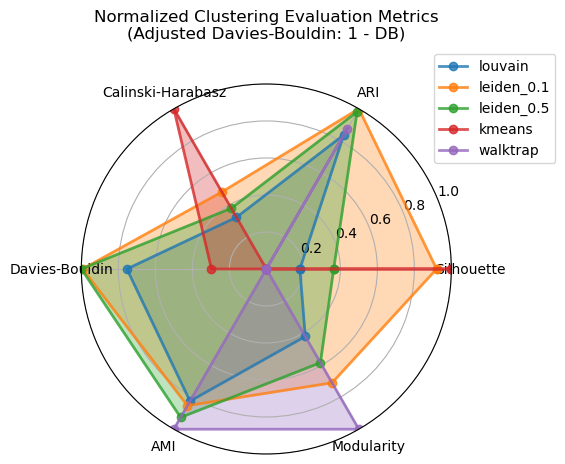

In [ ]:
# ------------------------------
# Step 1: Normalize each metric using min-max normalization
# ------------------------------
df_norm = df_metrics.copy()
for col in df_norm.columns:
    df_norm[col] = (df_norm[col] - df_norm[col].min()) / (df_norm[col].max() - df_norm[col].min())

# ------------------------------
# Step 2: Adjust the Davies-Bouldin Index
# ------------------------------
# Since a lower Davies-Bouldin index is better, we convert it to (1 - DB)
# so that all metrics are oriented such that higher values are better.
if 'Davies-Bouldin' in df_norm.columns:
    df_norm['Davies-Bouldin'] = 1 - df_norm['Davies-Bouldin']

# ------------------------------
# Step 3: Plot a radar chart (adjust transparency, line width, and figure size to reduce overlap)
# ------------------------------
categories = list(df_norm.columns)
methods = list(df_norm.index)
N = len(categories)

# Calculate the angles for each axis of the radar chart
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Complete the circle

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)

for method in methods:
    values = df_norm.loc[method].tolist()
    values += values[:1]  # Close the circle
    ax.plot(angles, values, marker='o', label=method, linewidth=2, alpha=0.8)
    ax.fill(angles, values, alpha=0.3)

# Set the labels for each axis and the range
ax.set_thetagrids(np.degrees(angles[:-1]), categories)
ax.set_ylim(0, 1)
plt.title("Normalized Clustering Evaluation Metrics\n(Adjusted Davies-Bouldin: 1 - DB)", y=1.10)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()


##### Note on Normalization for Visualization

This plot tends to exaggerate differences between methods when the raw scores are actually very similar because min–max normalization stretches the scale based on the observed minimum and maximum values. To avoid misrepresenting small differences, we choose not to normalize using the min–max approach.

#### Alternative Metric Normalization Based on Inherent Scales

In this section, we normalize our clustering evaluation metrics while respecting their inherent scales instead of using simple min–max scaling across the observed values. For example, metrics such as the Adjusted Rand Index (ARI) and Silhouette Score naturally range from -1 to 1, so we transform them to [0, 1] using the formula:


$\text{Normalized Score} = \frac{\text{Score} + 1}{2}$

For the Davies–Bouldin Index, where lower values are better, we first invert the metric by subtracting the normalized value from 1. For metrics like Calinski–Harabasz and Modularity, which do not have a fixed theoretical range, we perform min–max normalization based on the observed values.

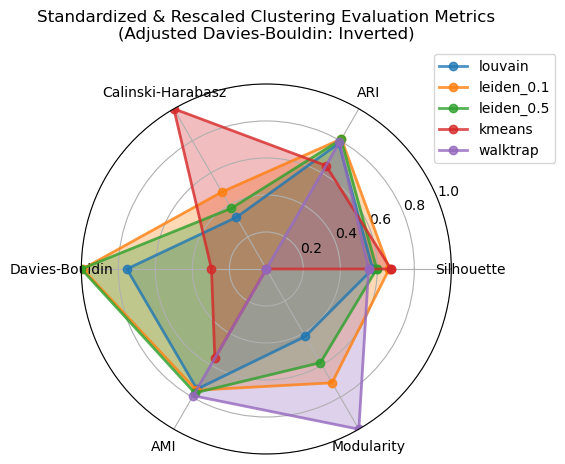

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df_transformed = df_metrics.copy()

# ------------------------------
# Step 1: Transform ARI and Silhouette Scores
# ------------------------------
# These metrics typically range from -1 to 1, so we convert them to a 0–1 scale.
if 'ARI' in df_transformed.columns:
    df_transformed['ARI'] = (df_transformed['ARI'] + 1) / 2
if 'Silhouette' in df_transformed.columns:
    df_transformed['Silhouette'] = (df_transformed['Silhouette'] + 1) / 2

# ------------------------------
# Step 2: Adjust and Normalize the Davies–Bouldin Index
# ------------------------------
# Since lower Davies–Bouldin scores are better, we invert the scale and then apply min–max normalization.
if 'Davies-Bouldin' in df_transformed.columns:
    db_min = df_transformed['Davies-Bouldin'].min()
    db_max = df_transformed['Davies-Bouldin'].max()
    df_transformed['Davies-Bouldin'] = 1 - (df_transformed['Davies-Bouldin'] - db_min) / (db_max - db_min)

# ------------------------------
# Step 3: Min–Max Normalize Other Metrics
# ------------------------------
# For Calinski–Harabasz Score and Modularity, use min–max normalization.
if 'Calinski-Harabasz' in df_transformed.columns:
    ch_min = df_transformed['Calinski-Harabasz'].min()
    ch_max = df_transformed['Calinski-Harabasz'].max()
    df_transformed['Calinski-Harabasz'] = (df_transformed['Calinski-Harabasz'] - ch_min) / (ch_max - ch_min)
if 'Modularity' in df_transformed.columns:
    mod_min = df_transformed['Modularity'].min()
    mod_max = df_transformed['Modularity'].max()
    df_transformed['Modularity'] = (df_transformed['Modularity'] - mod_min) / (mod_max - mod_min)

# AMI is assumed to be in [0, 1] already, so we leave it unchanged.

# ------------------------------
# Step 4: Plot a Radar Chart with the Rescaled Scores
# ------------------------------
categories = list(df_transformed.columns)
methods = list(df_transformed.index)
N = len(categories)

# Calculate the angles for each axis of the radar chart
angles = np.linspace(0, 2 * np.pi, N, endpoint=False).tolist()
angles += angles[:1]  # Close the circle

plt.figure(figsize=(6, 6))
ax = plt.subplot(111, polar=True)

for method in methods:
    values = df_transformed.loc[method].tolist()
    values += values[:1]  # Close the circle for plotting
    ax.plot(angles, values, marker='o', label=method, linewidth=2, alpha=0.8)
    ax.fill(angles, values, alpha=0.3)

# Set the labels for each axis and fix the radial limits to [0, 1]
ax.set_thetagrids(np.degrees(angles[:-1]), categories)
ax.set_ylim(0, 1)
plt.title("Standardized & Rescaled Clustering Evaluation Metrics\n(Adjusted Davies-Bouldin: Inverted)", y=1.10)
plt.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
plt.tight_layout()
plt.show()

### Visulization of the clusters

---



#### Unified Color Mapping Functions for Cluster Annotations

The following code defines functions to create a unified color dictionary across multiple annotation columns. This ensures that the same label appears in *the* same color across different clustering results.

- **`map_clusters_by_overlap(adata, col_a, col_b)`**  
  - Builds a contingency table (cross-tabulation) of overlapping cell counts between two annotation columns (`col_a` and `col_b`).
  - Returns a mapping dictionary where each label in `col_a` is mapped to the label in `col_b` with which it has the largest overlap.  
  - NaN values are dropped, and all labels are converted to strings.

- **`unify_colors_for_two_cols(adata, col_a, col_b, base_cmap=plt.cm.get_cmap('tab20'))`**  
  - Uses the overlap mapping between `col_a` and `col_b` to assign the same color to matching labels.
  - Generates a list of colors from a specified colormap (default is `tab20`) for all unique labels across the two columns.
  - Returns a dictionary that maps each label (from both columns) to a specific color.

- **`extend_colors_to_third_col(adata, existing_color_dict, col_a, col_third, base_cmap=plt.cm.get_cmap('tab20'))`**  
  - Extends an existing color dictionary (which already maps labels from `col_a`) to also cover a third column (`col_third`).
  - It uses the overlap between `col_a` and `col_third` to assign the same colors to matching labels, and assigns new colors for any labels in `col_third` that are not already mapped.

In [ ]:
def map_clusters_by_overlap(adata, col_a, col_b):
    """
    Returns a dictionary that maps each label in col_a to the label in col_b with which
    it has the largest overlap, ignoring NaN values.
    """
    # Convert both columns to strings and drop NaN values
    cluster_a_values = adata.obs[col_a].dropna().astype(str).unique()
    cluster_b_values = adata.obs[col_b].dropna().astype(str).unique()

    # Build a contingency table of overlaps
    overlap_table = pd.crosstab(adata.obs[col_a].astype(str), adata.obs[col_b].astype(str))

    mapping = {}
    for a_val in cluster_a_values:
        # Check if a_val is in the table index
        if a_val not in overlap_table.index:
            continue
        row = overlap_table.loc[a_val]
        # If the row is empty, skip
        if row.empty:
            continue
        best_b = row.idxmax()  # label in col_b with the largest overlap
        mapping[a_val] = best_b
    return mapping

def unify_colors_for_two_cols(adata, col_a, col_b, base_cmap=plt.cm.get_cmap('tab20')):
    """
    Create a color dictionary that assigns the same color to each pair of labels
    from col_a and col_b that have the largest overlap.
    """
    # Convert both columns to strings and drop NaNs
    cats_a = sorted(adata.obs[col_a].dropna().astype(str).unique())
    cats_b = sorted(adata.obs[col_b].dropna().astype(str).unique())
    combined_cats = sorted(set(cats_a + cats_b))

    # Generate enough colors for all unique categories
    num_colors = len(combined_cats)
    color_list = [base_cmap(i / max(1, num_colors - 1)) for i in range(num_colors)]

    # Create mapping for col_a: assign unique colors
    color_dict = {}
    for i, cat_a in enumerate(cats_a):
        color_dict[cat_a] = color_list[i]

    # Map each col_a label to a col_b label with largest overlap
    overlap_map = map_clusters_by_overlap(adata, col_a, col_b)

    used_b = set()
    for cat_a, cat_b in overlap_map.items():
        color_dict[cat_b] = color_dict[cat_a]
        used_b.add(cat_b)

    # For any col_b label that wasn't mapped, assign a new color.
    remaining_b = [b for b in cats_b if b not in used_b]
    idx = len(cats_a)
    for cat_b in remaining_b:
        color_dict[cat_b] = color_list[idx]
        idx += 1

    return color_dict

def extend_colors_to_third_col(adata, existing_color_dict, col_a, col_third, base_cmap=plt.cm.get_cmap('tab20')):
    """
    Extend an existing color dictionary (already containing colors for col_a)
    to include a third column (col_third) by mapping col_a -> col_third.
    """
    overlap_map = map_clusters_by_overlap(adata, col_a, col_third)

    # Convert third column to string and get unique labels
    cats_third = sorted(adata.obs[col_third].dropna().astype(str).unique())

    # Update the existing color dict with any mapping from col_a to col_third
    used_third = set()
    for a_val, third_val in overlap_map.items():
        if a_val in existing_color_dict:
            existing_color_dict[third_val] = existing_color_dict[a_val]
            used_third.add(third_val)

    # For any remaining third-col labels, assign new colors.
    remaining_third = [t for t in cats_third if t not in used_third]
    # Determine how many colors are already used:
    num_used = len(existing_color_dict)
    total_needed = num_used + len(remaining_third)
    color_list = [base_cmap(i / max(1, total_needed - 1)) for i in range(total_needed)]

    # Update the existing dictionary with new colors for remaining labels.
    idx = num_used
    for val in remaining_third:
        existing_color_dict[val] = color_list[idx]
        idx += 1

    return existing_color_dict

# Example full workflow for three columns: 'broad_cell_type', 'leiden_0.1', and 'kmeans'
# Step 1: Unify colors between 'broad_cell_type' and 'leiden_0.1'
color_dict_2cols = unify_colors_for_two_cols(adata, 'broad_cell_type', 'leiden_0.1')

# Step 2: Extend the color mapping to include 'kmeans'
color_dict_3cols = extend_colors_to_third_col(adata, color_dict_2cols, 'broad_cell_type', 'kmeans')


/tmp/ipykernel_655607/281044224.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  def unify_colors_for_two_cols(adata, col_a, col_b, base_cmap=plt.cm.get_cmap('tab20')):
/tmp/ipykernel_655607/281044224.py:62: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  def extend_colors_to_third_col(adata, existing_color_dict, col_a, col_third, base_cmap=plt.cm.get_cmap('tab20')):


#### UMAP Visualization 1

The following code plots the UMAP embedding for three annotation columns:  
- **Broad Cell Type** (`broad_cell_type`)  
- **Leiden Clustering** (`leiden_0.1`)  
- **KMeans Clustering** (`kmeans`)  


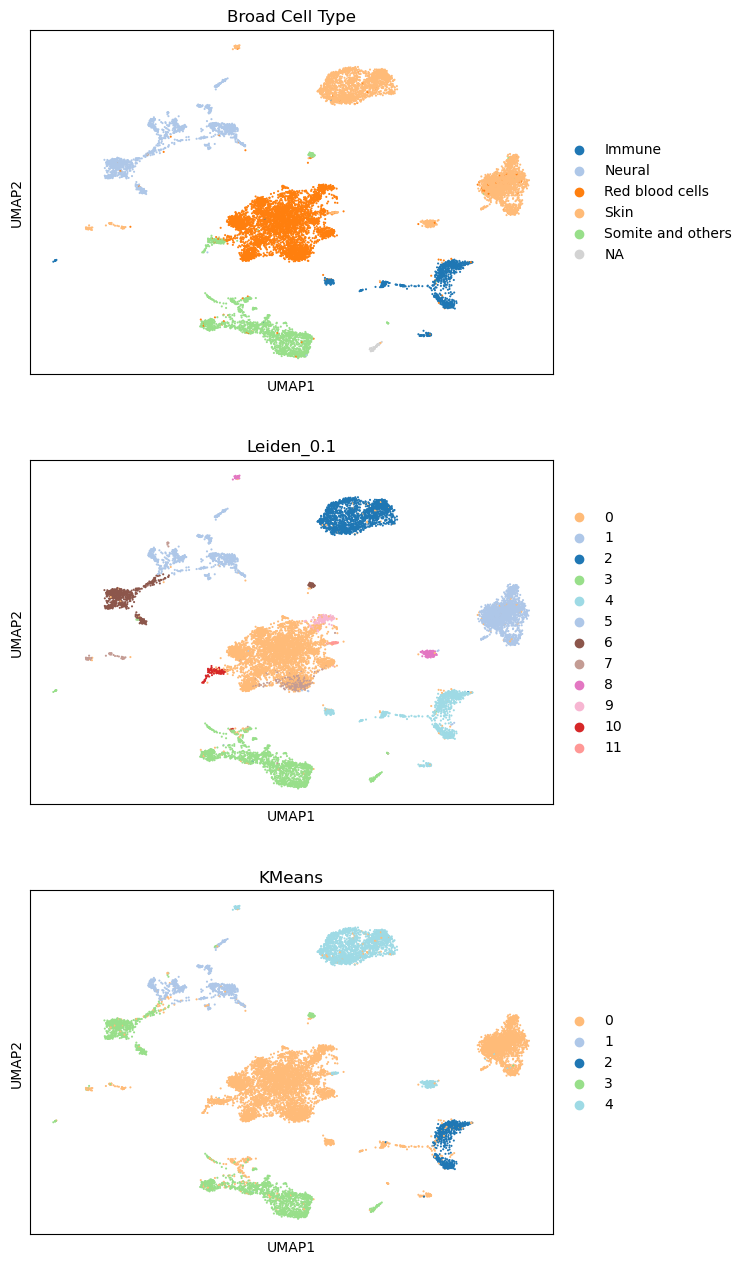

In [ ]:
# Plot UMAP for the three columns using the unified palette
sc.pl.umap(
    adata,
    color=['broad_cell_type','leiden_0.1','kmeans'],
    palette=color_dict_3cols,
    ncols=1,
    title=['Broad Cell Type','Leiden_0.1','KMeans'],
    legend_loc='right margin'
)

#### UMAP Visualization 2

The following code plots the UMAP embedding for four annotation columns:  
- **All Cell Types** (`cluster`)  
- **Louvain Clustering** (`louvain`)  
- **Leiden Clustering** (`leiden_0.5`)  
- **Walktrap Clustering** (`walktrap`)

Combined labels: ['0', '1', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '2', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '3', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '4', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '52', '53', '54', '55', '6', '7', '8', '9', 'Alpha ionocyte', 'Anterior notochord', 'Beta ionocyte', 'Dermomyotome', 'Differentiating myocyte', 'Differentiating neuron', 'Dopaminergic neurons', 'Epidermis', 'Erythrocyte 1', 'Erythrocyte 2', 'Erythrocyte 3', 'Erythrocyte 4', 'Floor plate', 'Goblet cell', 'Interneuron 1', 'Interneuron 2', 'Interneuron 3', 'Interneuron 4', 'Lymphoid 1 (Gata2-, Gata3+)', 'Lymphoid 2 (Cxcr6+)', 'Lymphoid 3', 'Lymphoid 4 (Gata2+, Gata3-)', 'Lymphoid 5 (CD19+)', 'Lymphoid endothelial cells', 'Melanocyte', 'Melanocyte precursor', 'Melanocyte stem cell', 'Mesenchyme', 'Motor neuron', 'Motor neuron (leptin+)', 'Myeloid 1', 'Myeloid 2', 'Myotome', 'Oligodendrocyte', 'P

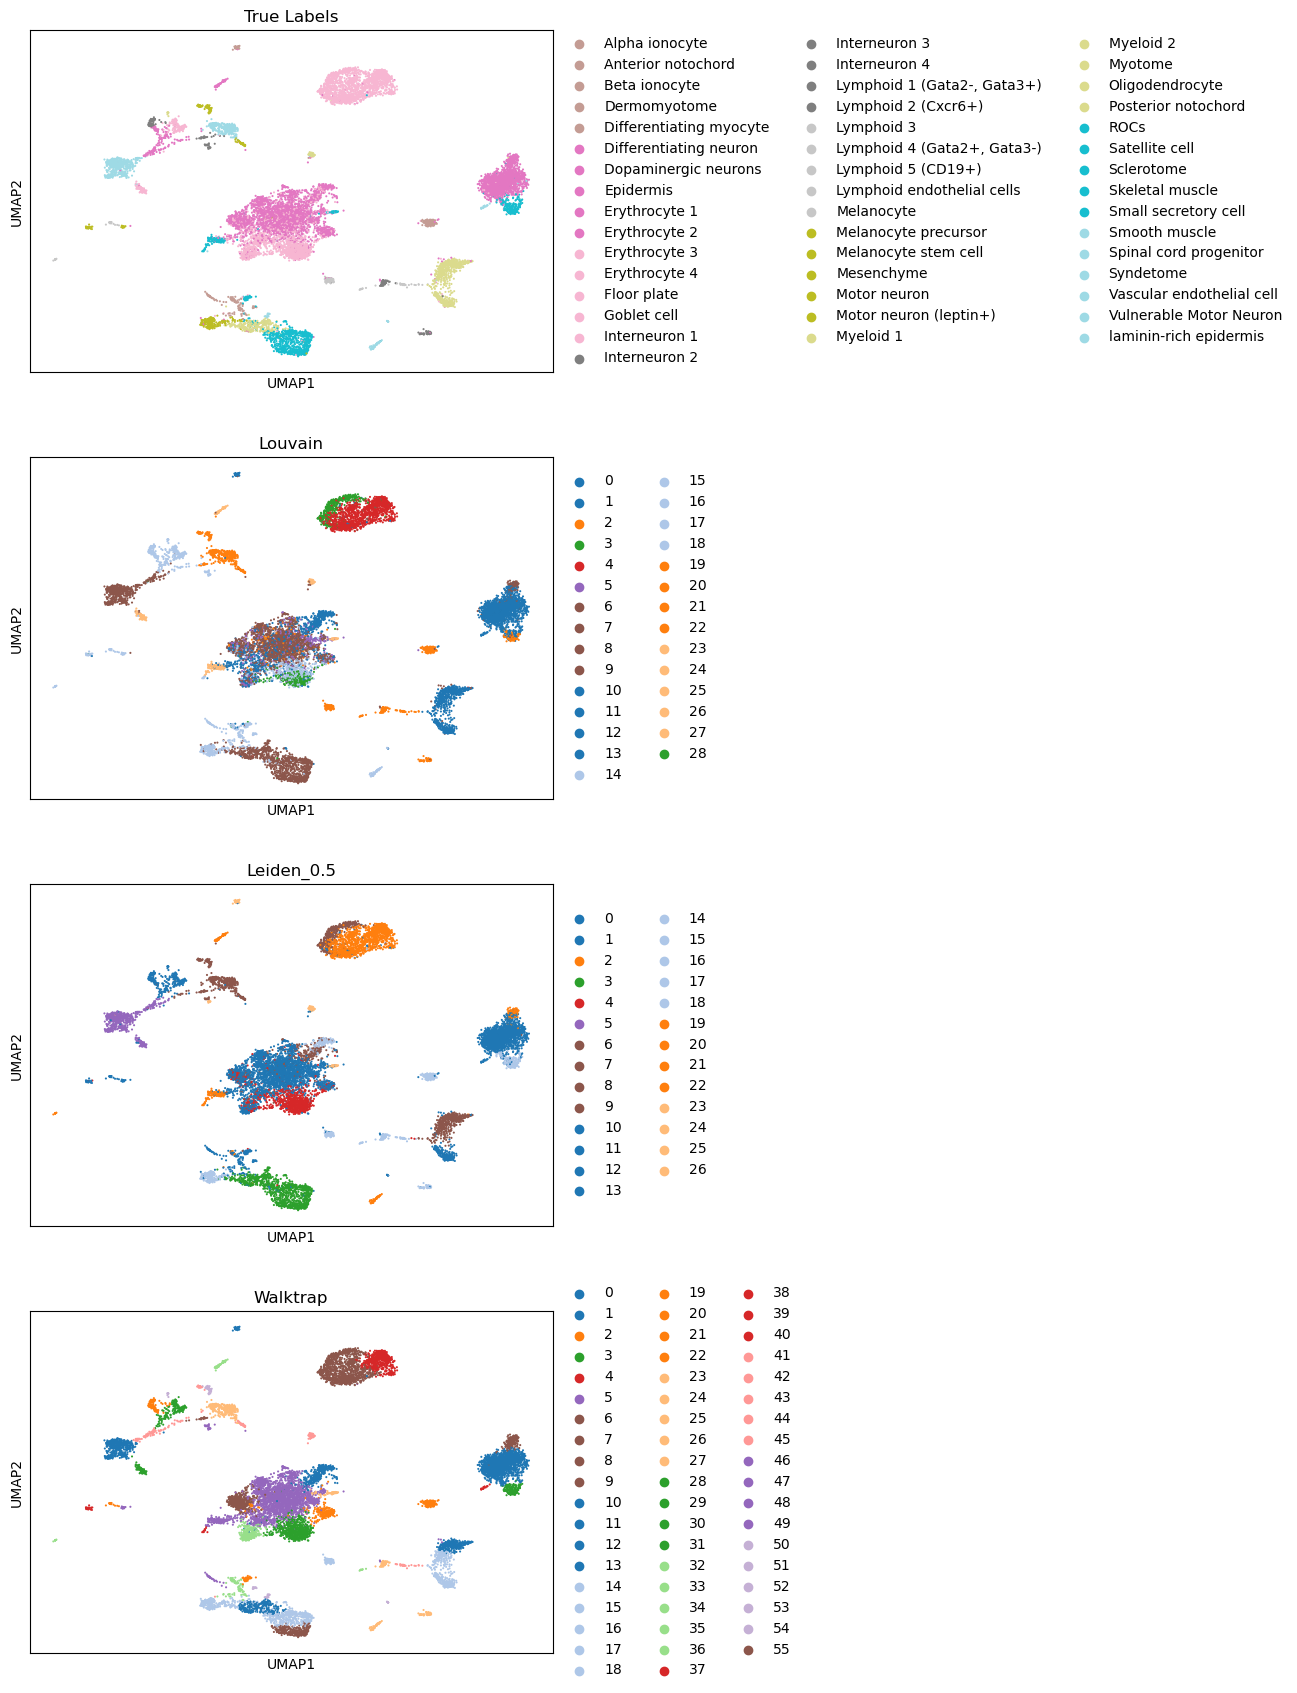

In [ ]:
# Define the columns to include in the unified color scheme.
cols = ['cluster', 'louvain', 'leiden_0.5', 'walktrap']

# Get the union of all unique labels from these columns (convert to strings and drop NaN)
combined_labels = set()
for col in cols:
    combined_labels = combined_labels.union(set(adata.obs[col].dropna().astype(str).unique()))
combined_labels = sorted(list(combined_labels))
print("Combined labels:", combined_labels)

# Create a unified color palette using a colormap (e.g., 'tab20')
num_labels = len(combined_labels)
cmap = plt.get_cmap('tab20')
# Generate a list of hex colors for all labels
colors = [
    '#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255))
    for r, g, b, _ in cmap(np.linspace(0, 1, num_labels))
]
# Create a dictionary mapping each label to its color
unified_palette = {label: color for label, color in zip(combined_labels, colors)}
print("Unified palette:", unified_palette)

# Plot UMAP for all four annotation columns using the unified palette.
sc.pl.umap(
    adata,
    color=cols,
    palette=unified_palette,
    title=['True Labels', 'Louvain', 'Leiden_0.5', 'Walktrap'],
    ncols=1,
    legend_loc='right margin'
)


## Section 3: Marker Gene Overlap Analysis For Cluster Annotation




### Select the `leiden_0.1` clustering result to replicate Figure 1.A from the paper

In this section, we compare marker gene profiles between broad cell types and Leiden clusters using three statistical methods: **Wilcoxon**, **t-test**, and **logistic regression**. **Note:**

The analysis follows these steps:

1. **Run Marker Gene Analysis for Each Method**  
   - For each method (Wilcoxon, t-test, logreg), we run marker gene analysis on:
     - **Broad cell types** (grouped by `broad_cell_type`), storing results with keys like `broad_rank_wilcox`, `broad_rank_t-test`, and `broad_rank_logreg`.
     - **Leiden clusters** (using the `leiden_0.1` grouping), storing results under keys such as `leiden_rank_wilcox`, `leiden_rank_t-test`, and `leiden_rank_logreg`.

2. **Extract Top 50 Marker Genes**  
   - For each broad cell type, we extract the top 50 marker genes (for each method) and store them in a dictionary (`broad_marker_sets`).
   - Similarly, for each Leiden cluster (specifically from `leiden_0.1`), we extract the top 50 marker genes (for each method) and store them in a dictionary (`leiden_marker_sets`).

3. **Define a Fuzzy Overlap Function**  
   - We define a helper function `fuzzy_overlap_fraction` that calculates the fraction of genes in one marker list that fuzzy-match (using case-insensitive substring checks) any gene in another list.
   - This function provides a quantitative measure of the similarity between marker gene sets from broad cell types and those from the selected Leiden clusters.

4. **Build Overlap Matrices for Each Method**  
   - For each method, we construct an overlap matrix where:
     - **Rows** represent broad cell types.
     - **Columns** represent Leiden clusters (from `leiden_0.1`).
     - Each cell in the matrix indicates the fraction of the top 50 marker genes from a broad cell type that fuzzy-match the top 50 markers of a Leiden cluster.
   - These matrices enable direct comparison of marker gene overlap across methods.

5. **Visualize the Overlap Matrices as Heatmaps**  
   - We display the overlap matrices for all three methods side by side using heatmaps.
   - This visualization helps us determine which marker gene method best captures the overlap between the broad cell type markers and the Leiden clusters, as used in Figure 1.A of the article.


In [ ]:
# --- Preprocessing: Replace "na" and NaN values in 'broad_cell_type'
# adata.obs['broad_cell_type'] = adata.obs['broad_cell_type'].fillna("unannotated")
adata.obs['broad_cell_type'] = adata.obs['broad_cell_type'].astype(str).replace("nan", "unannotated", regex=True)

[wilcoxon] Broad cell type 'Red blood cells': 50 markers (first 5): ['hbg1.L', 'tal1.L', 'Xelaev18032295m.g', 'hbg1.S', 'Xelaev18014009m.g']
[wilcoxon] Broad cell type 'Immune': 50 markers (first 5): ['cttn.like.1.L', 'rab44.L', 'parvg.S', 'sla.L', 'plek.L']
[wilcoxon] Broad cell type 'Skin': 50 markers (first 5): ['adap1.L', 'irf6.2.S', 'gjb3.S', 'loc100493579.like.L', 'loc100485898.like.L']
[wilcoxon] Broad cell type 'Somite and others': 50 markers (first 5): ['cd44.S', 'loxl3.S', 'tmem119.L', 'col5a1.like.S', 'pdgfra.L']
[wilcoxon] Broad cell type 'Neural': 50 markers (first 5): ['gdap1l1.L', 'Xelaev18046309m.g', 'tusc3.L', 'unnamed.L.12', 'cadps.L']
[wilcoxon] Broad cell type 'unannotated': 50 markers (first 5): ['prx.L', 'icam5.S', 'cav1.L', 'cdh5.L', 'cetp.L']
[t-test] Broad cell type 'Red blood cells': 50 markers (first 5): ['hbg1.L', 'hbg1.S', 'Xelaev18014009m.g', 'Xelaev18032295m.g', 'tal1.L']
[t-test] Broad cell type 'Immune': 50 markers (first 5): ['cttn.like.1.L', 'parvg.S'

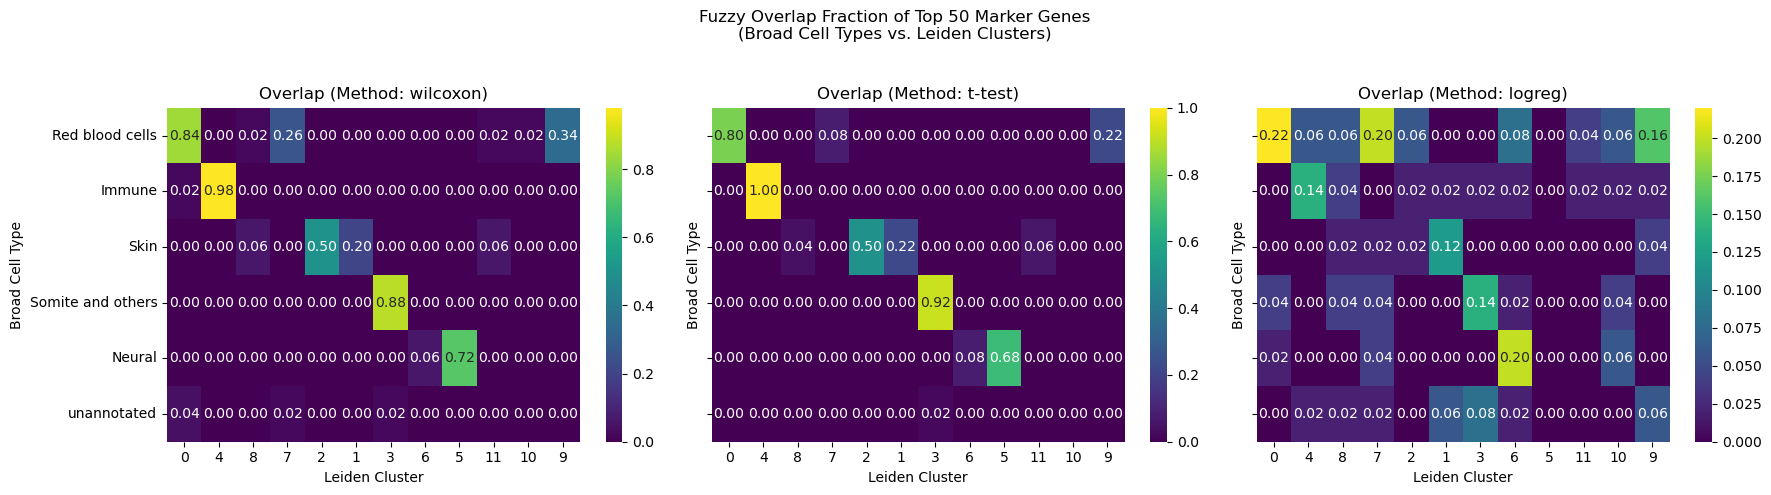

In [ ]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ------------------------------
# Step 0: Run Marker Gene Analysis for Each Method
# ------------------------------
methods = ['wilcoxon', 't-test', 'logreg']
for m in methods:
    # For broad cell types: use key 'broad_rank_{method}'
    sc.tl.rank_genes_groups(adata, groupby='broad_cell_type', method=m, key_added=f'broad_rank_{m}')
    # For Leiden clusters (from 'leiden_0.1'): use key 'leiden_rank_{method}'
    sc.tl.rank_genes_groups(adata, groupby='leiden_0.1', method=m, key_added=f'leiden_rank_{m}', max_iter=1000)

# ------------------------------
# Step 1: Extract Top Marker Genes for Broad Cell Types for Each Method
# ------------------------------
broad_types = adata.obs['broad_cell_type'].dropna().astype(str).unique()
broad_marker_sets = {m: {} for m in methods}

for m in methods:
    for bt in broad_types:
        try:
            df_bt = sc.get.rank_genes_groups_df(adata, group=bt, key=f'broad_rank_{m}')
        except KeyError:
            print(f"Broad group '{bt}' not found for method {m}.")
            continue
        top_genes = df_bt['names'].head(50).tolist()
        broad_marker_sets[m][bt] = set(top_genes)
        print(f"[{m}] Broad cell type '{bt}': {len(broad_marker_sets[m][bt])} markers (first 5): {top_genes[:5]}")

# ------------------------------
# Step 2: Extract Top Marker Genes for Leiden Clusters for Each Method
# ------------------------------
leiden_clusters = adata.obs['leiden_0.1'].dropna().astype(str).unique()
leiden_marker_sets = {m: {} for m in methods}

for m in methods:
    for lc in leiden_clusters:
        try:
            df_lc = sc.get.rank_genes_groups_df(adata, group=lc, key=f'leiden_rank_{m}')
        except KeyError:
            print(f"Leiden group '{lc}' not found for method {m}.")
            continue
        top_genes = df_lc['names'].head(50).tolist()
        leiden_marker_sets[m][lc] = set(top_genes)
        print(f"[{m}] Leiden cluster '{lc}': {len(leiden_marker_sets[m][lc])} markers (first 5): {top_genes[:5]}")

# ------------------------------
# Step 3: Define a Fuzzy Overlap Function
# ------------------------------
def fuzzy_overlap_fraction(markers1, markers2):
    """
    Returns the fraction of markers in markers1 that fuzzy-match any gene in markers2,
    using a case-insensitive substring check.
    """
    count = 0
    for m in markers1:
        for marker in markers2:
            if marker.lower() in m.lower() or m.lower() in marker.lower():
                count += 1
                break
    return count / len(markers1) if markers1 else 0

# ------------------------------
# Step 4: Build Overlap Matrices for Each Method
# ------------------------------
overlap_matrices = {}

for m in methods:
    # Create a DataFrame to hold overlap fractions (rows: broad cell types, columns: Leiden clusters)
    overlap_df = pd.DataFrame(index=broad_types, columns=leiden_clusters)
    for bt in broad_types:
        for lc in leiden_clusters:
            fraction = fuzzy_overlap_fraction(
                list(broad_marker_sets[m][bt]),
                list(leiden_marker_sets[m][lc])
            )
            overlap_df.loc[bt, lc] = fraction
    overlap_matrices[m] = overlap_df.astype(float)
    print(f"\nOverlap matrix for method {m}:")
    print(overlap_df)

# ------------------------------
# Step 5: Visualize the Overlap Matrices as Heatmaps (Side by Side)
# ------------------------------
fig, axes = plt.subplots(1, len(methods), figsize=(6 * len(methods), 5), sharey=True)

for i, m in enumerate(methods):
    sns.heatmap(overlap_matrices[m], annot=True, fmt=".2f", cmap='viridis', ax=axes[i])
    axes[i].set_title(f"Overlap (Method: {m})")
    axes[i].set_xlabel("Leiden Cluster")
    axes[i].set_ylabel("Broad Cell Type")

plt.suptitle("Fuzzy Overlap Fraction of Top 50 Marker Genes\n(Broad Cell Types vs. Leiden Clusters)")
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Annotation Comparison: ARI and UMAP Visualization

In this section, we generate leiden-based annotations based on fuzzy overlap and compare multiple cluster annotations by visualizing the umap. We focus on four annotation columns:
- **broad_cell_type**: The true (or manually defined) broad cell type labels.
- **leiden_annotation_wilcox**: Leiden cluster annotations based on Wilcoxon marker analysis.
- **leiden_annotation_ttest**: Leiden cluster annotations based on t-test marker analysis.
- **leiden_annotation_logreg**: Leiden cluster annotations based on logistic regression marker analysis.

ARI for leiden_annotation_wilcoxon vs. True Labels: 0.914
ARI for leiden_annotation_t-test vs. True Labels: 0.930
ARI for leiden_annotation_logreg vs. True Labels: 0.535


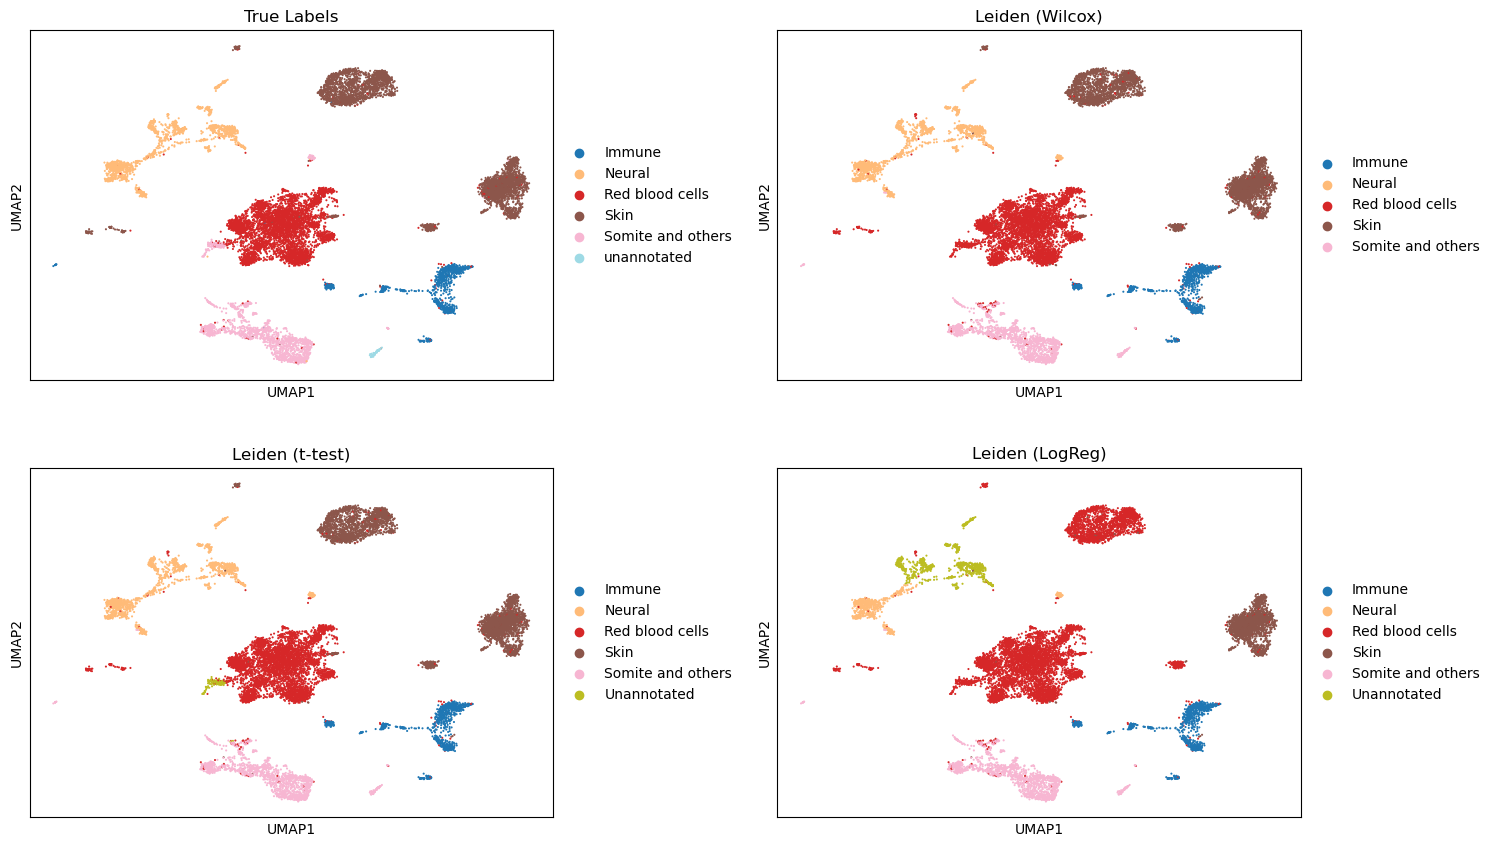

In [ ]:
# ------------------------------
# Step 6: Generate Leiden-Based Annotations Based on Fuzzy Overlap
# ------------------------------

annotation_results = {}
for m in methods:
    ann_dict = {}
    for lc in leiden_clusters:
        # Retrieve the top marker gene set for this Leiden cluster using method m.
        marker_set_lc = leiden_marker_sets[m].get(lc, set())
        overlaps = {}
        for bt in broad_types:
            # Retrieve the top marker gene set for the broad cell type using the same method.
            marker_set_bt = broad_marker_sets[m].get(bt, set())
            overlaps[bt] = fuzzy_overlap_fraction(list(marker_set_lc), list(marker_set_bt))
        # Determine the broad cell type with the highest overlap.
        best_bt = max(overlaps, key=overlaps.get)
        if overlaps[best_bt] == 0:
            best_bt = "Unannotated"
        ann_dict[lc] = best_bt
    annotation_results[m] = ann_dict
    # Map the annotation back into adata.obs with a new column for method m.
    adata.obs[f'leiden_annotation_{m}'] = adata.obs['leiden_0.1'].astype(str).map(ann_dict)

# ------------------------------
# Step 7: Unified Annotation Comparison and UMAP Visualization
# ------------------------------
import seaborn as sns
from sklearn.metrics import adjusted_rand_score

# Define the annotation columns, including the true labels.
annotation_cols = ['broad_cell_type', 'leiden_annotation_wilcoxon', 'leiden_annotation_t-test', 'leiden_annotation_logreg']

# Combine unique labels from all annotation columns (convert to strings and drop NaNs).
combined_labels = set()
for col in annotation_cols:
    combined_labels = combined_labels.union(set(adata.obs[col].dropna().astype(str).unique()))
combined_labels = sorted(list(combined_labels))

# Generate a unified color palette using a colormap (here 'tab20').
num_labels = len(combined_labels)
cmap = plt.get_cmap('tab20')
colors = ['#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255))
          for r, g, b, _ in cmap(np.linspace(0, 1, num_labels))]
unified_palette = {label: color for label, color in zip(combined_labels, colors)}

# ------------------------------
# Compute ARI between true labels and each Leiden annotation method.
# ------------------------------
for col in annotation_cols[1:]:
    ari = adjusted_rand_score(adata.obs['broad_cell_type'], adata.obs[col].astype(str))
    print(f"ARI for {col} vs. True Labels: {ari:.3f}")

# ------------------------------
# Plot UMAP for each annotation using the unified color palette.
# ------------------------------
sc.pl.umap(
    adata,
    color=annotation_cols,
    palette=unified_palette,
    ncols=2,
    wspace=0.3,
    title=['True Labels', 'Leiden (Wilcox)', 'Leiden (t-test)', 'Leiden (LogReg)'],
    legend_loc='right margin'
)

Based on the comparisons above, the marker gene analyses using the **Wilcoxon** and **t-test** methods performed better than the **logistic regression approach**. **T-test method** achieved the highest ARI score. Therefore, for the subsequent analysis steps, we choose to use the **t-test method**.


### Subsetting and Clustering Skin Cells

To further analyze skin-specific cell populations, we subset the data to include only cells that have been annotated as **"Skin"** based on the t-test method.

#### Steps:
1. **Subset the Data**: Extract cells labeled as "Skin" from the Leiden annotation.
2. **Run PCA**: Perform principal component analysis (PCA) on the skin subset, reducing dimensionality while retaining key variance.
3. **Construct the Neighbors Graph**: Compute the k-nearest neighbor graph using 10 principal components (n_pcs = 10).
4. **Compute UMAP Embedding**: Generate a UMAP visualization for the skin cell subset.
5. **Leiden Clustering**: Run Leiden clustering with a resolution of **0.4** to identify subclusters within the skin cell population.


In [ ]:
# Subset the data to only include cells annotated as "skin"
adata_skin = adata[adata.obs['leiden_annotation_t-test'] == 'Skin'].copy()

# Run PCA on the skin subset (if not already computed)
sc.pp.pca(adata_skin, n_comps=10)

# Compute the neighbors graph using the PCA results
sc.pp.neighbors(adata_skin, n_neighbors=10, n_pcs=10)

# Compute UMAP embedding for visualization on the subset
sc.tl.umap(adata_skin, random_state=42)

# Run Leiden clustering on the skin subset
# Adjust the resolution parameter to obtain roughly 10 clusters (e.g., try resolution=1.0)
sc.tl.leiden(adata_skin, resolution=0.4, key_added='skin_leiden')

### Annotating Skin Leiden Clusters Based on Marker Gene Overlap

In this section, we annotate clusters from the skin subset (obtained via last step Leiden clustering) by comparing their marker genes with those from the original (true) clusters.

In [ ]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt

# ---------------------------
# Step 1: Compute Marker Genes for Original Clusters
# ---------------------------
# Run marker gene analysis for the original clusters (stored in adata.obs['cluster'])
sc.tl.rank_genes_groups(adata, groupby='cluster', method='t-test', key_added='rank_cluster')

# Create a dictionary to store the top 50 marker genes for each original cluster
original_clusters = adata.obs['cluster'].dropna().unique()
orig_marker_sets = {}
for cl in original_clusters:
    # Extract a DataFrame with marker gene results for cluster 'cl'
    df_cl = sc.get.rank_genes_groups_df(adata, group=cl, key='rank_cluster')
    # Take the top 50 marker gene names
    top_genes = df_cl['names'].head(50).tolist()
    orig_marker_sets[cl] = set(top_genes)
    print(f"Original cluster '{cl}' marker genes (first 5): {top_genes[:5]} ...")

# ---------------------------
# Step 2: Compute Marker Genes for Skin Leiden Clusters
# ---------------------------
# Run marker gene analysis for the skin subset clusters (stored in adata_skin.obs['skin_leiden'])
sc.tl.rank_genes_groups(adata_skin, groupby='skin_leiden', method='t-test', key_added='rank_skin')

# Create a dictionary to store the top 50 marker genes for each skin cluster
skin_leiden_clusters = adata_skin.obs['skin_leiden'].dropna().unique()
skin_marker_sets = {}
for cl in skin_leiden_clusters:
    df_cl_skin = sc.get.rank_genes_groups_df(adata_skin, group=cl, key='rank_skin')
    top_genes_skin = df_cl_skin['names'].head(50).tolist()
    skin_marker_sets[cl] = set(top_genes_skin)
    print(f"Skin Leiden cluster '{cl}' marker genes (first 5): {top_genes_skin[:5]} ...")

# ---------------------------
# Step 3: Define Fuzzy Overlap Function
# ---------------------------
def fuzzy_overlap(marker_set1, marker_set2):
    """
    Count the number of genes in marker_set1 that fuzzy match any gene in marker_set2,
    using a case-insensitive substring check.
    """
    count = 0
    for gene1 in marker_set1:
        for gene2 in marker_set2:
            if gene1.lower() in gene2.lower() or gene2.lower() in gene1.lower():
                count += 1
                break  # Count each gene only once
    return count

# ---------------------------
# Step 4: Annotate Skin Leiden Clusters Based on Marker Overlap
# ---------------------------
skin_annotations = {}
for skin_cl in skin_leiden_clusters:
    skin_set = skin_marker_sets[skin_cl]
    overlaps = {}
    for orig_cl, orig_set in orig_marker_sets.items():
        overlaps[orig_cl] = fuzzy_overlap(skin_set, orig_set)
    best_orig = max(overlaps, key=overlaps.get)
    if overlaps[best_orig] == 0:
        best_orig = "Unannotated"
    skin_annotations[skin_cl] = best_orig
    print(f"Skin Leiden cluster '{skin_cl}': overlaps: {overlaps}, assigned as '{best_orig}'")

# ---------------------------
# Step 5: Map Annotations to adata_skin.obs
# ---------------------------
adata_skin.obs['skin_annotation'] = adata_skin.obs['skin_leiden'].map(skin_annotations)

# ---------------------------
# Step 6: Visualize the Annotated Clusters with a Custom Palette
# ---------------------------
# Create a custom palette that assigns the same color to the same annotation.
# Get the unique annotations (sorted for consistency)
unique_annots = sorted(adata_skin.obs['skin_annotation'].unique())
print("Unique annotations:", unique_annots)


/home/fangxy/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/fangxy/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/fangxy/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:434: PerformanceWarning: DataFrame is highly fra

Original cluster 'Erythrocyte 4' marker genes (first 5): ['ccnb3.L', 'ccnb3.S', 'kif11.L', 'plk1.S', 'plk1.L'] ...
Original cluster 'Myeloid 1' marker genes (first 5): ['tspan36.L', 'Xelaev18038149m.g', 'trem2.S', 'cttn.like.1.L', 'c1qa.L'] ...
Original cluster 'Beta ionocyte' marker genes (first 5): ['atp6v1g3.S', 'atp6v1g3.L', 'atp6v0a4.L', 'foxi1.L', 'atp6ap1.1.L'] ...
Original cluster 'Goblet cell' marker genes (first 5): ['loc100485898.like.L', 'gjb1.L', 'Xelaev18024247m.g', 'loc100216141.S', 'MGC64389'] ...
Original cluster 'Erythrocyte 1' marker genes (first 5): ['hbg1.L', 'Xelaev18014009m.g', 'tal1.L', 'Xelaev18032295m.g', 'dydc1.L'] ...
Original cluster 'Epidermis' marker genes (first 5): ['Xetrov90014283m.L', 'tp63.S', 'lama3.L', 'wnt7b.L', 'sema3a.L'] ...
Original cluster 'Sclerotome' marker genes (first 5): ['chadl.L', 'nkx3.2.L', 'loxl3.S', 'plod2.L', 'ntn1.S'] ...
Original cluster 'Myotome' marker genes (first 5): ['pdgfra.L', 'pdgfra.S', 'colec12.S', 'tmem119.L', 'Xelaev

### Annotation Visualization and Clustering Evaluation

We then plot the UMAP embedding and evaluate the clustering agreement using Adjusted Rand Index (ARI), Adjusted Mutual Information (AMI), and Silhouette Score.


Combined labels: ['Alpha ionocyte', 'Beta ionocyte', 'Epidermis', 'Erythrocyte 1', 'Erythrocyte 3', 'Erythrocyte 4', 'Goblet cell', 'Interneuron 1', 'Lymphoid 5 (CD19+)', 'Myeloid 2', 'Myotome', 'ROCs', 'Skeletal muscle', 'Small secretory cell', 'Spinal cord progenitor', 'Vascular endothelial cell', 'Vulnerable Motor Neuron', 'laminin-rich epidermis']
Unified palette: {'Alpha ionocyte': '#1f77b4', 'Beta ionocyte': '#aec7e8', 'Epidermis': '#ff7f0e', 'Erythrocyte 1': '#ffbb78', 'Erythrocyte 3': '#2ca02c', 'Erythrocyte 4': '#98df8a', 'Goblet cell': '#ff9896', 'Interneuron 1': '#9467bd', 'Lymphoid 5 (CD19+)': '#c5b0d5', 'Myeloid 2': '#8c564b', 'Myotome': '#c49c94', 'ROCs': '#e377c2', 'Skeletal muscle': '#7f7f7f', 'Small secretory cell': '#c7c7c7', 'Spinal cord progenitor': '#bcbd22', 'Vascular endothelial cell': '#dbdb8d', 'Vulnerable Motor Neuron': '#17becf', 'laminin-rich epidermis': '#9edae5'}


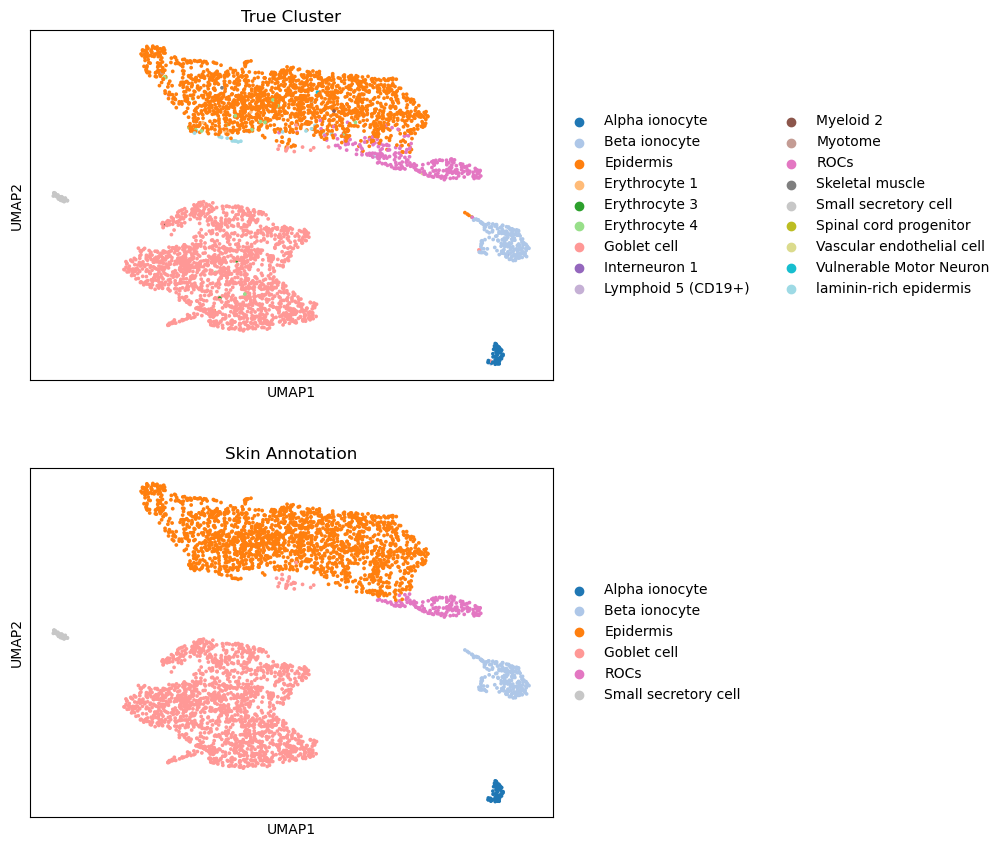

ARI between True Cluster and Skin Annotation: 0.913
AMI between True Cluster and Skin Annotation: 0.876
Silhouette Score for Skin Annotation: 0.497


In [ ]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score


# ------------------------------
# Step 1: Create a Unified Color Palette
# ------------------------------
# Combine unique labels from both annotations
combined_labels = sorted(set(adata_skin.obs['cluster'].unique()).union(set(adata_skin.obs['skin_annotation'].unique())))
print("Combined labels:", combined_labels)

# Generate a unified color palette using a colormap.
# If there are more than 10 labels, use 'tab20' to ensure enough colors.
if len(combined_labels) > 10:
    cmap = plt.get_cmap('tab20')
else:
    cmap = plt.get_cmap('tab10')

num_labels = len(combined_labels)
colors = ['#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255))
          for r, g, b, _ in cmap(np.linspace(0, 1, num_labels))]
unified_palette = {label: colors[i] for i, label in enumerate(combined_labels)}
print("Unified palette:", unified_palette)

# ------------------------------
# Step 2: Plot UMAP for Both Annotations with Unified Colors
# ------------------------------
sc.pl.umap(
    adata_skin,
    color=['cluster', 'skin_annotation'],
    palette=unified_palette,
    ncols=1,
    title=['True Cluster', 'Skin Annotation'],
    legend_loc='right margin'
)

# ------------------------------
# Step 3: Evaluate Clustering Agreement and Quality
# ------------------------------
true_labels = adata_skin.obs['cluster']
predicted_labels = adata_skin.obs['skin_annotation']

# Compute Adjusted Rand Index (ARI) and Adjusted Mutual Information (AMI)
ari = adjusted_rand_score(true_labels, predicted_labels)
ami = adjusted_mutual_info_score(true_labels, predicted_labels)

# Compute Silhouette Score using the PCA embedding.
# (Higher silhouette indicates better-defined clusters.)
pca_data = adata_skin.obsm['X_pca']
silhouette = silhouette_score(pca_data, predicted_labels)

print(f"ARI between True Cluster and Skin Annotation: {ari:.3f}")
print(f"AMI between True Cluster and Skin Annotation: {ami:.3f}")
print(f"Silhouette Score for Skin Annotation: {silhouette:.3f}")


### ROC Marker Gene Overlap

Assess the overlap of marker genes in skin clusters annotated as "ROCs" with the original ROC marker set.

In [ ]:
# Define fuzzy_common (if not already defined)
def fuzzy_common(top_markers, marker_set):
    """
    Return a set of genes from top_markers that fuzzy match any gene in marker_set.
    Matching is case-insensitive and uses substring matching.
    """
    common = set()
    for m in top_markers:
        for marker in marker_set:
            if marker.lower() in m.lower() or m.lower() in marker.lower():
                common.add(m)
                break
    return common

# Identify skin Leiden clusters annotated as "ROCs" (or containing "roc" in their label)
roc_skin_clusters = [cl for cl, annot in skin_annotations.items() if "roc" in annot.lower()]
if len(roc_skin_clusters) == 0:
    print("No skin Leiden cluster annotated as ROC found.")
else:
    for roc_cl in roc_skin_clusters:
        # Extract the top 50 marker genes for this skin cluster (from logistic regression or Wilcoxon)
        df_roc = sc.get.rank_genes_groups_df(adata_skin, group=roc_cl, key='rank_skin')
        top_markers_skin = set(df_roc['names'].head(50).tolist())

        # Determine the original marker set for ROC.
        # If the original broad cell type for ROC is labeled "ROCs", then use that set.
        # Otherwise, try to find a broad cell type whose name contains "roc".
        orig_marker_set = None
        if "ROCs" in orig_marker_sets:
            orig_marker_set = orig_marker_sets["ROCs"]
        else:
            for key in orig_marker_sets.keys():
                if "roc" in key.lower():
                    orig_marker_set = orig_marker_sets[key]
                    break
        if orig_marker_set is None:
            print("No original ROC marker set found.")
            continue

        # Compute the overlapping genes using fuzzy matching.
        overlap_genes = fuzzy_common(top_markers_skin, orig_marker_set)
        print(f"Overlapping marker genes for skin Leiden cluster '{roc_cl}' (annotated as ROC):")
        print(len(list(overlap_genes)))  # print top 9 overlapping genes


Overlapping marker genes for skin Leiden cluster '8' (annotated as ROC):
44


### Counting ROC-annotated Cells

In this section, we quantify the number of cells classified as "ROCs" in different subsets of the data:

1. **Original Data**:  
   We count the number of cells in the full dataset (`adata`) whose true cluster label (stored in `adata.obs['cluster']`) is "ROCs".

2. **Skin Subset Annotation**:  
   We count the number of cells in the skin subset (`adata_skin`) where the skin-specific annotation (stored in `adata_skin.obs['skin_annotation']`) is "ROCs".

3. **Intersection of Annotations**:  
   Finally, we count the number of cells in the skin subset that are annotated as "ROCs" in both the original cluster labels and the skin-specific annotations.

This allows us to assess the consistency between the original clustering and our self-generated skin subset annotation for ROC cells.



In [ ]:
# Count cells in the original data (adata) with cluster "ROCs"
N_cells_original = adata.obs[adata.obs['cluster'] == 'ROCs'].shape[0]
print("Number of cells in adata with cluster 'ROCs':", N_cells_original)

# Count cells in the skin subset (adata_skin) with skin_annotation "ROCs"
N_cells_skin_annotation = adata_skin.obs[adata_skin.obs['skin_annotation'] == 'ROCs'].shape[0]
print("Number of cells in adata_skin with skin_annotation 'ROCs':", N_cells_skin_annotation)

# Count cells in the skin subset (adata_skin) where both the original cluster and the skin_annotation are "ROCs"
n_cells = adata_skin.obs[(adata_skin.obs['cluster'] == 'ROCs') &
                          (adata_skin.obs['skin_annotation'] == 'ROCs')].shape[0]
print("Number of cells with cluster 'ROCs' and skin_annotation 'ROCs':", n_cells)


Number of cells in adata with cluster 'ROCs': 254
Number of cells in adata_skin with skin_annotation 'ROCs': 152
Number of cells with cluster 'ROCs' and skin_annotation 'ROCs': 151


### Counting Cells Based on Skin Annotations

In this section, we count the number of cells that are annotated as "Skin" based on two different annotation sources in the original dataset (`adata.obs`):

1. **Broad Cell Type**:  
   Count cells where the `broad_cell_type` column is equal to `"Skin"`.

2. **Leiden Annotation**:  
   Count cells where the `leiden_annotation` column is equal to `"Skin"`.

3. **Intersection**:  
   Count cells where both `broad_cell_type` and `leiden_annotation` are `"Skin"`.

This comparison helps to evaluate the consistency between the broad cell type annotations and the refined Leiden-based annotations for skin cells.


In [ ]:
# Count cells in adata.obs where 'broad_cell_type' is "Skin"
N_cells_broad = adata.obs[adata.obs['broad_cell_type'] == 'Skin'].shape[0]
print("Number of cells with broad_cell_type 'Skin':", N_cells_broad)

# Count cells in adata.obs where 'leiden_annotation' is "skin"
N_cells_leiden = adata.obs[adata.obs['leiden_annotation_t-test'] == 'Skin'].shape[0]
print("Number of cells with leiden_annotation 'skin':", N_cells_leiden)

# Count cells where both conditions are met
n_cells = adata.obs[(adata.obs['broad_cell_type'] == 'Skin') & (adata.obs['leiden_annotation_t-test'] == 'Skin')].shape[0]
print("Number of cells with broad_cell_type 'Skin' and leiden_annotation 'skin':", n_cells)


Number of cells with broad_cell_type 'Skin': 4212
Number of cells with leiden_annotation 'skin': 4112
Number of cells with broad_cell_type 'Skin' and leiden_annotation 'skin': 4077


In [ ]:
list(overlap_genes)

['nid2.S',
 'rspo2.L',
 'sema3f.L',
 'lamb2.L',
 'lamb1.S',
 'sema6d.L',
 'snai2.S',
 'fgf7.S',
 'Xelaev18044182m.g',
 'optc.S',
 'sp9.L',
 'fgf9.L',
 'dlx2.L',
 'Xetrov90029035m.L',
 'egfl6.L',
 'mmp19.like.2.L',
 'fbn2.S',
 'col27a1.S',
 'cpa6.S',
 'dlx2.S',
 'fgf7.L',
 'cpa6.L',
 'lpar3.L',
 'nckap5l.S',
 'loc100498358.L',
 'unc5b.S',
 'igfbp2.L',
 'gdf6.L',
 'krt.L',
 'tp73.L',
 'Xelaev18034799m.g',
 'loc100492954.S',
 'ism2.L',
 'tinagl1.S',
 'vwde.L',
 'lef1.S',
 'jag1.L',
 'lamb1.L',
 'c3.L',
 'fgfr4.L',
 'ackr3.L',
 'Xelaev18046800m.g',
 'loc100488523.L',
 'wnt5a.S']

### ROC Marker Overlap Analysis

In this section, we assess the similarity between our identified marker genes and the set of genes known to be associated with ROC cells provided by the article (Table S3).


In [ ]:
target_genes = [
    "wnt5a",
    "loc100488523",
    "loc100492954",
    "egfl6",
    "lpar3",
    "cpa6",
    "sp9",
    "fgf9",
    "fbn2",
    "tinagl1",
    "fgf7",
    "vwde",
    "lef1",
    "lamb2",
    "fgfr4",
    "fgf7",
    "rspo2",
    "cpa6",
    "loc100498358",
    "krt",
    "loc100486832",
    "jag1",
    "Xelaev18043128m",
    "dlx2",
    "tp73",
    "gdf6",
    "Xelaev18046800m",
    "nid2",
    "igfbp2",
    "ism2",
    "dlx2",
    "loc100493805",
    "frem2",
    "Xelaev18044182m",
    "bmp5",
    "tspear",
    "sema3f",
    "robo4",
    "jchain",
    "rspo2",
    "adamts18",
    "pltp",
    "Xelaev18034799m",
    "lamb1",
    "lamb1",
    "unc5b",
    "mmp28",
    "fgf10",
    "pzp",
    "galnt15"
]

# 3. Define fuzzy matching functions

def fuzzy_overlap_count(list1, list2):
    """
    Return how many genes in list1 fuzzy-match any gene in list2
    (case-insensitive substring checks).
    """
    count = 0
    for g1 in list1:
        for g2 in list2:
            if g1.lower() in g2.lower() or g2.lower() in g1.lower():
                count += 1
                break  # avoid double-counting the same gene
    return count

def fuzzy_overlap_genes(list1, list2):
    """
    Return the actual set of genes from list1 that fuzzy-match any gene in list2.
    """
    matched = set()
    for g1 in list1:
        for g2 in list2:
            if g1.lower() in g2.lower() or g2.lower() in g1.lower():
                matched.add(g1)
                break
    return matched

# 4. Compute fuzzy overlap count and matched genes
count = fuzzy_overlap_count(overlap_genes, target_genes)
matched_genes = fuzzy_overlap_genes(overlap_genes, target_genes)

print(f"Fuzzy overlap count: {count}")
print("Matched genes:")
for mg in matched_genes:
    print("  ", mg)


Fuzzy overlap count: 35
Matched genes:
   nid2.S
   rspo2.L
   sema3f.L
   lamb1.S
   fgf7.S
   Xelaev18044182m.g
   sp9.L
   fgf9.L
   dlx2.L
   egfl6.L
   fbn2.S
   loc100488523.L
   cpa6.S
   dlx2.S
   fgf7.L
   cpa6.L
   lpar3.L
   loc100498358.L
   unc5b.S
   igfbp2.L
   gdf6.L
   krt.L
   tp73.L
   Xelaev18034799m.g
   loc100492954.S
   ism2.L
   tinagl1.S
   vwde.L
   lef1.S
   jag1.L
   lamb1.L
   fgfr4.L
   Xelaev18046800m.g
   lamb2.L
   wnt5a.S


## Section 4: Another method
Trying without subsetting the skin cells, instead, we directly use the Walktrap cluster annotation to identify "ROCs".


---


### Walktrap Cluster Annotation and Evaluation with ROC Marker Overlap

This section of the analysis compares marker gene profiles between the true clusters (stored in `adata.obs['cluster']`) and the Walktrap clusters (stored in `adata.obs['walktrap']`) using the Wilcoxon test. It also evaluates the clustering performance using several metrics and examines the overlap of marker genes in clusters annotated as "ROCs" with a target gene list.

#### Step-by-Step Description:

1. **Marker Gene Analysis**  
   - **(A) Walktrap Clusters**:  
     Run marker gene analysis on the Walktrap clusters using the Wilcoxon test. The results are stored with the key `walktrap_rank`.
   - **(B) True Clusters**:  
     Run marker gene analysis on the true clusters (from `adata.obs['cluster']`) using the Wilcoxon test, with results stored under the key `cluster_rank`.

2. **Extraction of Top Marker Genes (Top 50)**  
   - For each true cluster, the top 50 marker genes are extracted and stored in the dictionary `true_marker_sets`.
   - Similarly, for each Walktrap cluster, the top 50 marker genes are extracted and stored in `walktrap_marker_sets`.

3. **Fuzzy Overlap Function**  
   - The function `fuzzy_overlap` is defined to count the number of genes in one marker set that fuzzy-match any gene in another set using a case-insensitive substring check.

4. **Annotation of Walktrap Clusters**  
   - For each Walktrap cluster, the fuzzy overlap between its marker gene set and the marker gene set of each true cluster is computed.
   - The true cluster label with the highest overlap is assigned as the annotation for the Walktrap cluster (if no overlap is found, the cluster is labeled `"Unannotated"`).
   - These annotations are stored in the dictionary `walktrap_annotation` and mapped back to the AnnData object as a new column, `adata.obs['walktrap_annotation']`.

5. **Unified Color Palette for Visualization**  
   - A unified color palette is created by combining the unique labels from both `cluster` (true labels) and `walktrap_annotation`.
   - This palette ensures that identical labels appear with the same color when visualizing UMAP embeddings.

6. **UMAP Visualization**  
   - UMAP plots are generated to display the true cluster labels and the Walktrap-based annotations side by side, using the unified color palette.

7. **Clustering Evaluation**  
   - The clustering agreement between the true labels and the Walktrap-based annotations is quantified using:
     - **Adjusted Rand Index (ARI)**
     - **Adjusted Mutual Information (AMI)**
     - **Silhouette Score** (computed from the PCA embedding)
   - These metrics provide insight into the quality and consistency of the clustering.

8. **ROC Marker Overlap Analysis**  
   - If any Walktrap cluster is annotated as `"ROCs"`, the top 50 marker genes for that cluster are extracted.
   - A fuzzy matching function (`fuzzy_overlap_genes`) is used to determine the overlap between these marker genes and a predefined `target_genes` list.
   - The number of overlapping genes and the list of overlapping markers are printed to assess how well the ROC markers are represented.

This comprehensive workflow allows us to annotate and evaluate Walktrap clusters, compare them with the true clusters, and specifically examine the ROC cell markers.


/home/fangxy/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:429: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "names"] = self.var_names[global_indices]
/home/fangxy/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:431: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, "scores"] = scores[global_indices]
/home/fangxy/anaconda3/lib/python3.11/site-packages/scanpy/tools/_rank_genes_groups.py:434: PerformanceWarning: DataFrame is highly fra

Walktrap cluster '0': Overlaps: {'Erythrocyte 4': 15, 'Myeloid 1': 0, 'Beta ionocyte': 0, 'Goblet cell': 0, 'Erythrocyte 1': 16, 'Epidermis': 0, 'Sclerotome': 0, 'Myotome': 0, 'Spinal cord progenitor': 0, 'Myeloid 2': 1, 'Mesenchyme': 0, 'ROCs': 0, 'Melanocyte': 0, 'Erythrocyte 3': 13, 'Differentiating neuron': 0, 'Satellite cell': 0, 'Vascular endothelial cell': 0, 'Vulnerable Motor Neuron': 0, 'Alpha ionocyte': 0, 'Lymphoid 1 (Gata2-, Gata3+)': 0, 'Lymphoid 2 (Cxcr6+)': 0, 'Erythrocyte 2': 37, 'Interneuron 1': 0, 'Skeletal muscle': 1, 'Lymphoid 4 (Gata2+, Gata3-)': 1, 'Small secretory cell': 1, 'Floor plate': 0, 'Dermomyotome': 0, 'Interneuron 2': 0, 'Dopaminergic neurons': 1, 'Lymphoid 5 (CD19+)': 0, 'Interneuron 4': 0, 'Melanocyte stem cell': 0, 'laminin-rich epidermis': 0, 'Motor neuron (leptin+)': 1, 'Motor neuron': 0, 'Lymphoid 3': 0, 'Posterior notochord': 0, 'Melanocyte precursor': 0, 'Anterior notochord': 0, 'Interneuron 3': 0, 'Smooth muscle': 0, 'Syndetome': 0, 'Differentia

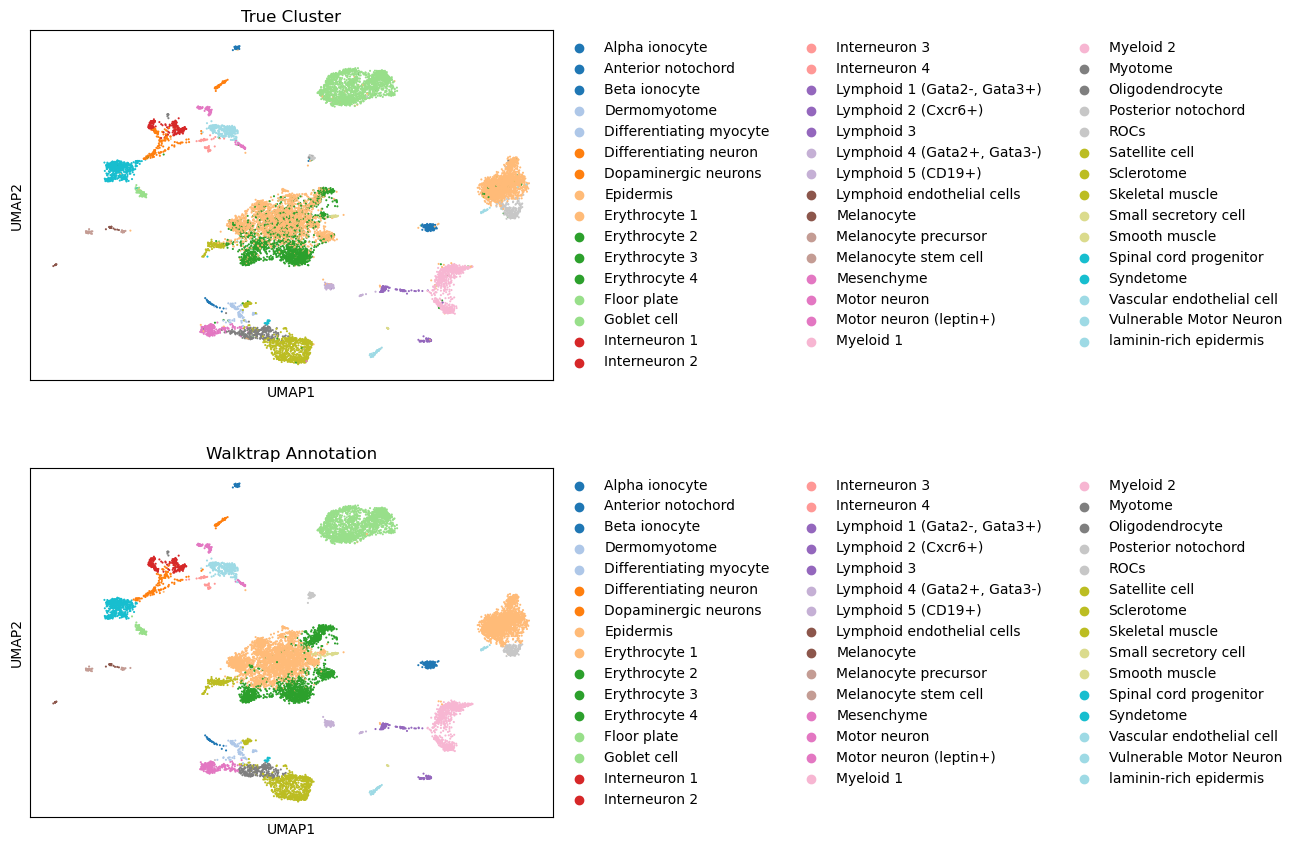

Silhouette Score (Walktrap vs True Labels): 0.113
ARI (Walktrap vs True Labels): 0.726
AMI (Walktrap vs True Labels): 0.837

Top 50 marker genes for the 'ROCs' walktrap cluster (29):
['nid2.S', 'frem2.S', 'rspo2.L', 'sema3f.L', 'lamb1.S', 'snai2.S', 'mmp28.L', 'fgf7.S', 'Xelaev18044182m.g', 'optc.S', 'sp9.L', 'fgf9.L', 'dlx2.L', 'fzd10.L', 'Xetrov90029035m.L', 'egfl6.L', 'mmp19.like.2.L', 'fbn2.S', 'col27a1.S', 'loc100488523.L', 'kremen2.L', 'cpa6.S', 'dlx2.S', 'fgf7.L', 'cpa6.L', 'st3gal2.2.S', 'lpar3.L', 'loc100498358.L', 'nckap5l.S', 'unc5b.S', 'igfbp2.L', 'krt.L', 'tp73.L', 'prss35.S', 'Xelaev18034799m.g', 'loc100492954.S', 'ism2.L', 'tinagl1.S', 'vwde.L', 'lef1.S', 'jag1.L', 'lamb1.L', 'c3.L', 'loc100486832.L', 'fgfr4.L', 'ackr3.L', 'Xelaev18046800m.g', 'lamb2.L', 'apcdd1.L', 'wnt5a.S']
Number of fuzzy-overlapping genes with target_genes: 37
Overlapping genes: {'nid2.S', 'frem2.S', 'rspo2.L', 'sema3f.L', 'lamb2.L', 'lamb1.S', 'mmp28.L', 'fgf7.S', 'Xelaev18044182m.g', 'sp9.L', 'fgf

In [ ]:
import pandas as pd
import scanpy as sc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import silhouette_score, adjusted_rand_score, adjusted_mutual_info_score

# ==============================
# Step 1: Marker Gene Analysis
# ==============================
# (A) Marker genes for Walktrap clusters
sc.tl.rank_genes_groups(adata, groupby='walktrap', method='wilcoxon', key_added='walktrap_rank')

# (B) Marker genes for true clusters
sc.tl.rank_genes_groups(adata, groupby='cluster', method='wilcoxon', key_added='cluster_rank')

# ==============================
# Step 2: Extract Top 50 Marker Genes for Each Group
# ==============================
# (A) True clusters
true_clusters = adata.obs['cluster'].dropna().unique().astype(str)
true_marker_sets = {}
for c in true_clusters:
    try:
        df_c = sc.get.rank_genes_groups_df(adata, group=c, key='cluster_rank')
    except KeyError:
        print(f"True cluster '{c}' not found in cluster_rank results.")
        continue
    top_genes = df_c['names'].head(50).tolist()
    true_marker_sets[c] = set(top_genes)

# (B) Walktrap clusters
walktrap_clusters = adata.obs['walktrap'].dropna().unique().astype(str)
walktrap_marker_sets = {}
for wcl in walktrap_clusters:
    try:
        df_wcl = sc.get.rank_genes_groups_df(adata, group=wcl, key='walktrap_rank')
    except KeyError:
        print(f"Walktrap cluster '{wcl}' not found in walktrap_rank results.")
        continue
    top_genes = df_wcl['names'].head(50).tolist()
    walktrap_marker_sets[wcl] = set(top_genes)

# ==============================
# Step 3: Define Fuzzy Overlap Function
# ==============================
def fuzzy_overlap(marker_set1, marker_set2):
    """
    Count the number of genes in marker_set1 that fuzzy match any gene in marker_set2,
    using a case-insensitive substring check.
    """
    count = 0
    for gene1 in marker_set1:
        for gene2 in marker_set2:
            if gene1.lower() in gene2.lower() or gene2.lower() in gene1.lower():
                count += 1
                break
    return count

# ==============================
# Step 4: Annotate Walktrap Clusters by Matching with True Clusters
# ==============================
walktrap_annotation = {}
for wcl in walktrap_clusters:
    wcl_set = walktrap_marker_sets[wcl]
    overlaps = {}
    for c, c_set in true_marker_sets.items():
        overlaps[c] = fuzzy_overlap(wcl_set, c_set)
    best_true = max(overlaps, key=overlaps.get)
    if overlaps[best_true] == 0:
        best_true = "Unannotated"
    walktrap_annotation[wcl] = best_true
    print(f"Walktrap cluster '{wcl}': Overlaps: {overlaps}, assigned as '{best_true}'")

# Map these annotations back into adata.obs
adata.obs['walktrap_annotation'] = adata.obs['walktrap'].astype(str).map(walktrap_annotation)

# ==============================
# Step 5: Create a Unified Color Palette for cluster & walktrap_annotation
# ==============================
cols = ['cluster', 'walktrap_annotation']
combined_labels = set()
for col in cols:
    combined_labels = combined_labels.union(set(adata.obs[col].dropna().astype(str).unique()))
combined_labels = sorted(list(combined_labels))

# Use a colormap (e.g., tab20) to create a color dictionary
import matplotlib.pyplot as plt
cmap = plt.get_cmap('tab20')
num_labels = len(combined_labels)
colors = [
    '#%02x%02x%02x' % (int(r*255), int(g*255), int(b*255))
    for r, g, b, _ in cmap(np.linspace(0, 1, num_labels))
]
unified_palette = {label: color for label, color in zip(combined_labels, colors)}

# ==============================
# Step 6: Visualize UMAP
# ==============================
sc.pl.umap(
    adata,
    color=['cluster','walktrap_annotation'],
    palette=unified_palette,
    ncols=1,
    title=['True Cluster', 'Walktrap Annotation'],
    legend_loc='right margin'
)

# ==============================
# Step 7: Compute Clustering Scores
# ==============================
# For example, ARI, AMI, and Silhouette
true_labels = adata.obs['cluster'].astype(str)
predicted_labels = adata.obs['walktrap_annotation'].astype(str)

ari = adjusted_rand_score(true_labels, predicted_labels)
ami = adjusted_mutual_info_score(true_labels, predicted_labels)

# For silhouette, we assume PCA or UMAP is in adata.obsm
if 'X_pca' in adata.obsm:
    embedding_data = adata.obsm['X_pca']
elif 'X_umap' in adata.obsm:
    embedding_data = adata.obsm['X_umap']
else:
    embedding_data = None

if embedding_data is not None:
    silhouette = silhouette_score(embedding_data, predicted_labels)
    print(f"Silhouette Score (Walktrap vs True Labels): {silhouette:.3f}")
else:
    silhouette = None
    print("No PCA/UMAP embedding found in adata.obsm. Silhouette score not computed.")

print(f"ARI (Walktrap vs True Labels): {ari:.3f}")
print(f"AMI (Walktrap vs True Labels): {ami:.3f}")

# ==============================
# Step 8: If there's a cluster labeled 'ROCs', output top 50 marker genes & overlap with target_genes
# ==============================
# Suppose you want to find if any walktrap_annotation cluster is labeled 'ROCs'
rocs_cluster = [k for k,v in walktrap_annotation.items() if v == 'ROCs']
if rocs_cluster:
    # We'll take the first such cluster if multiple
    rocs_cl = rocs_cluster[0]
    rocs_markers = list(walktrap_marker_sets[rocs_cl])  # top 50 from step 2
    print(f"\nTop 50 marker genes for the 'ROCs' walktrap cluster ({rocs_cl}):")
    print(rocs_markers)

    # Fuzzy overlap with target_genes
    def fuzzy_overlap_genes(list1, list2):
        matched = set()
        for g1 in list1:
            for g2 in list2:
                if g1.lower() in g2.lower() or g2.lower() in g1.lower():
                    matched.add(g1)
                    break
        return matched

    matched = fuzzy_overlap_genes(rocs_markers, target_genes)
    print(f"Number of fuzzy-overlapping genes with target_genes: {len(matched)}")
    print("Overlapping genes:", matched)
else:
    print("\nNo walktrap_annotation cluster labeled 'ROCs' was found.")


## Section 5 : Key Genes Expression Visualization

In this section, we visualize the expression of selected genes across different time points (DayPostAmputation = 0, 1, 2, 3) in all cells. The genes of interest mentioned in the article are:

- **Wnt5a** (represented as `wnt5a.L`)
- **Fgf10** (represented as `fgf10.L`)
- **Fgf20**
- **Msx1**
- **Bmpr1a**

Yet, we do not have the expression data of **Fgf20**, **Msx1**, **Bmpr1a** after HVGs filtration. So we focus on **Wnt5a** and **Fgf10**.


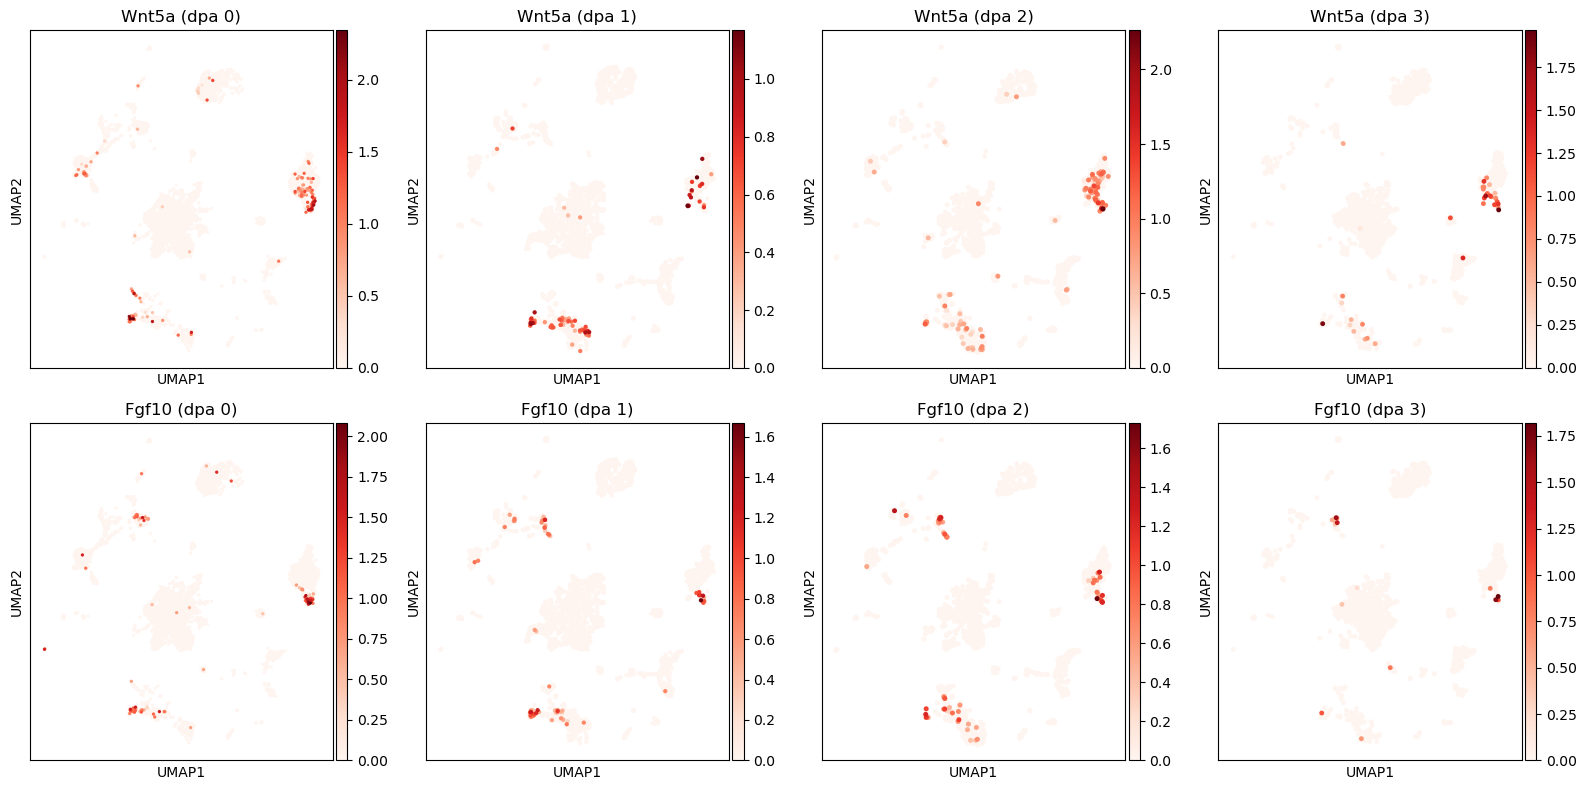

In [ ]:
import numpy as np
import scanpy as sc
import matplotlib.pyplot as plt
import pandas as pd

# Define the list of genes and their display names
genes = ["wnt5a.L", "fgf10.L"]
gene_names = ["Wnt5a", "Fgf10"]

# Define the DayPostAmputation (dpa) values to consider
dpa_values = [0, 1, 2, 3]

# Set up a grid for UMAP plots:
# Rows correspond to different genes; columns correspond to different dpa values.
# The figsize is defined as (width, height) where width = 4 * number of dpa values and height = 4 * number of genes.
fig, axes = plt.subplots(len(genes), len(dpa_values), figsize=(4 * len(dpa_values), 4 * len(genes)), sharex=True, sharey=True)

# Loop over each gene (row) and each dpa (column)
for i, gene in enumerate(genes):
    for j, dpa in enumerate(dpa_values):
        # Subset the data to the current dpa value
        adata_dpa = adata[adata.obs['DaysPostAmputation'] == dpa].copy()

        # Plot UMAP for the gene in the current dpa subset using a continuous color map (e.g., "Reds")
        sc.pl.umap(
            adata_dpa,
            color=gene,
            ax=axes[i, j],
            show=False,
            cmap='Reds',
            title=f"{gene_names[i]} (dpa {dpa})"
        )

plt.tight_layout()
plt.show()

### Identify Differentially Expressed ROC Marker Genes Across Days Post Amputation

In this step, we focus on the ROC marker genes (stored in `rocs_markers`) and evaluate how their expression varies across different DayPostAmputation (dpa) groups (0, 1, 2, 3). We use the following procedure:

1. **Calculate Mean Expression per Group:**  
   For each gene in `rocs_markers`, we compute the average expression in cells from each dpa group.

2. **Quantify Differential Expression:**  
   We use the range of the mean expression (i.e. _maximum mean expression_ minus _minimum mean expression_) as a measure of how differentially expressed each gene is across the dpa groups.

3. **Select Top Genes:**  
   The genes are then sorted by this range, and we select the top 10 genes showing the greatest differential expression. Their names are printed for review.

4. **Visualize Top Genes:**  
   Finally, the top 3 genes (from the top 10) are visualized using violin plots, which show the distribution of expression across the different dpa groups.

In [ ]:
# Define the DayPostAmputation groups to consider.
dpa_values = [0, 1, 2, 3]

# Dictionary to store the expression range (max - min) for each gene.
gene_diff = {}

# Loop over each gene in rocs_markers.
for gene in rocs_markers:
    means = []
    # Calculate the mean expression for the gene in each dpa group.
    for dpa in dpa_values:
        adata_dpa = adata[adata.obs['DaysPostAmputation'] == dpa]
        # Check if the gene is present in the dataset.
        if gene not in adata.var_names:
            continue
        expr = adata_dpa[:, gene].X
        # If the expression matrix is sparse, convert to a dense array.
        if hasattr(expr, "toarray"):
            expr = expr.toarray().flatten()
        else:
            expr = np.array(expr).flatten()
        mean_expr = np.mean(expr)
        means.append(mean_expr)
    # Only include genes for which we have data for all dpa groups.
    if len(means) == len(dpa_values):
        gene_range = max(means) - min(means)
        gene_diff[gene] = gene_range

# Sort genes by the computed differential range and select the top 10.
top10_genes = sorted(gene_diff, key=gene_diff.get, reverse=True)[:10]
print("Top 10 ROC markers with highest differential expression across dpa:")
for g in top10_genes:
    print(g)

Top 10 ROC markers with highest differential expression across dpa:
optc.S
col27a1.S
prss35.S
mmp19.like.2.L
Xetrov90029035m.L
ackr3.L
snai2.S
apcdd1.L
mmp28.L
lamb1.L


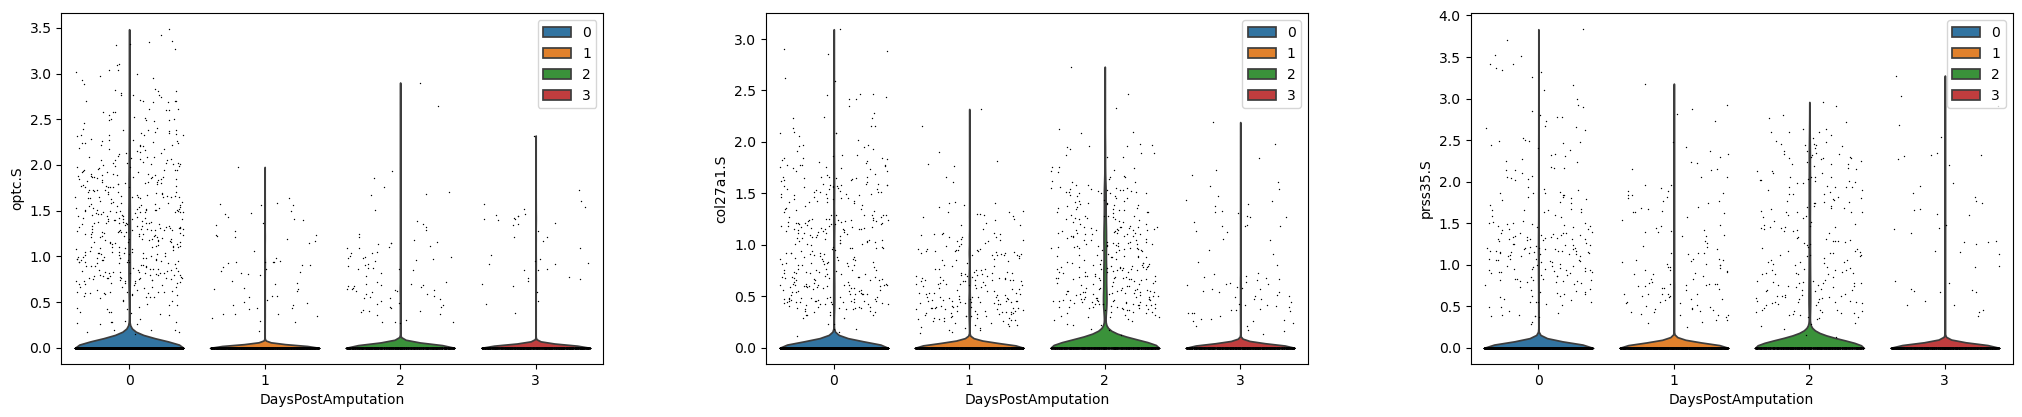

In [ ]:
# Select the top 3 genes for visualization.
top3_genes = top10_genes[:3]

# Convert 'DaysPostAmputation' to a categorical variable
adata.obs['DaysPostAmputation'] = adata.obs['DaysPostAmputation'].astype('category')

# Visualize the expression of the top 5 genes across different dpa groups using violin plots
sc.pl.violin(adata, keys=top3_genes, groupby='DaysPostAmputation', jitter=0.4, multi_panel=True)